In [1]:
# -*- coding: utf8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
import locale
# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.stattools import medcouple
from scipy.optimize import newton
from scipy.special import digamma
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# build report
import reportlab
from reportlab.platypus.flowables import Flowable
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, KeepTogether
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.platypus import Table, TableStyle

# the module that has all the methods for handling the data
import resources.featuredata as featuredata
from resources.featuredata import makeAList, small_space, large_space, aSingleStyledTable, smallest_space
from resources.featuredata import caption_style, subsection_title, title_style, block_quote_style
from resources.featuredata import figureAndCaptionTable, tableAndCaption, aStyledTableWithTitleRow
from resources.featuredata import sectionParagraphs, section_title, addToDoc, makeAParagraph, bold_block

# images and display
import matplotlib.image as mpimg
from myst_nb import glue

loc = locale.getlocale()
lang =  "de_CH.utf8"
locale.setlocale(locale.LC_ALL, lang)

# set some parameters:
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'threshold_values'
save_fig_prefix = "resources/output/"

save_figure_kwargs = {
    "fname": None,
    "dpi": 300.0,
    "format": "jpeg",
    "bbox_inches": None,
    "pad_inches": 0,
    "bbox_inches": 'tight',
    "facecolor": 'auto',
    "edgecolor": 'auto',
    "backend": None,
}


# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 100
unit_label = 'p/100 m'

# get your data:
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('location', inplace=True)

# index the code data
dfCodes.set_index("code", inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(threshhold)=
# Basiswerte für Abfallobjekte an Gewässern

{Download}`Download </resources/pdfs/baselines.pdf>`


Basiswerte (BVs), die auch als Benchmarks bezeichnet werden, sind die Mengen oder Werte, die zur statistischen Definition einer Situation verwendet werden. Die BVs beziehen sich auf eine Reihe von Daten, die sowohl zeitlich als auch geografisch begrenzt sind und auch als Referenzpunkt oder Basisperiode bezeichnet werden. BVs sind die Grössen, an denen der Fortschritt gemessen wird. In dieser Hinsicht sind die BVs eng mit den Daten und den zu ihrer Erhebung verwendeten Methoden verbunden.

## Zählen von Abfallobjekten am Strand: ein Überblick

Der erste internationale Leitfaden zur Erfassung von Abfallobjekten am Strand wurde 2008 vom Umweltprogramm der Vereinten Nationen (UNEP) und der Zwischenstaatlichen Ozeanographischen Kommission (IOC) veröffentlicht {cite}`unepseas`. Auf der Grundlage der gesammelten Arbeit vieler Forschenden wurde diese Methode 2010 von der OSPAR-Kommission übernommen {cite}`ospard10`,  2013 veröffentlichte die EU einen Leitfaden für die Überwachung mariner Abfallobjekte an den europäischen Meeren (_the guide_) {cite}`mlwguidance`. Die Schweiz ist Mitglied von OSPAR und hat über 1000 Proben nach den im the guide beschriebenen Methoden genommen.

Auf _the guide_ folgte 2016 Riverine Litter Monitoring - Options and Recommendations {cite}`riverinemonitor`, der die zunehmende Erkenntnis widerspiegelt, dass Flüsse wichtige Quellen für Haushaltsabfälle in Küstenregionen sind. Zu diesem Zeitpunkt war das erste Projekt zur Überwachung von Abfallobjekten am Genfer See bereits abgeschlossen und die Vorbereitungen für ein einjähriges nationales Projekt in der Schweiz, das von STOPPP initiiert und von WWF-Freiwilligen unterstützt wurde, liefen an, siehe [Vergleich der Datenerhebungen seit 2018](slr-iqaasl).

2019 veröffentlichte das Joint Research Centre (JRC) eine Analyse eines europäischen Datensatzes zu Abfallobjekten am Strand aus den Jahren 2012–2016, ein technisches Dokument, in dem die Methoden und verschiedenen Szenarien zur Berechnung von Basiswerten von Abfallobjekten am Strand detailliert beschrieben werden. Von besonderem Interesse für das JRC war die Robustheit der Methoden gegenüber Extremwerten und die Transparenz der Berechnungsmethode.{cite}`eubaselines`

Im September 2020 schliesslich legte die EU Basis- und Zielwerte auf der Grundlage der 2015–2016 erhobenen Daten fest. Die Zielwerte beziehen sich auf den guten Umweltzustand der Meeresgewässer, der in der Meeresstrategie-Rahmenrichtlinie (MSRL) beschrieben wird. Die Basiswerte wurden anhand der in der Veröffentlichung von 2019 beschriebenen Methoden berechnet.{cite}`threshholdeu`

In [2]:
pdfcomponents = []

the_title = Paragraph("Basiswerte für Abfallobjekte an Gewässern", title_style)

p_one = [
    "Basiswerte (BVs), die auch als Benchmarks bezeichnet werden, sind die Mengen oder Werte, die zur statistischen ",
    "Definition einer Situation verwendet werden. Die BVs beziehen sich auf eine Reihe von Daten, die sowohl zeitlich ",
    "als auch geografisch begrenzt sind und auch als Referenzpunkt oder Basisperiode bezeichnet werden. BVs sind die ",
    "Grössen, an denen der Fortschritt gemessen wird. In dieser Hinsicht sind die BVs eng mit den Daten und den zu ",
    "ihrer Erhebung verwendeten Methoden verbunden."
]

section_one_title = Paragraph("Zählen von Abfallobjekten am Strand: ein Überblick", section_title)

p_two = [
    "Der erste internationale Leitfaden zur Erfassung von Abfallobjekten am Strand wurde 2008 vom Umweltprogramm der ",
    "Vereinten Nationen (UNEP) und der Zwischenstaatlichen Ozeanographischen Kommission (IOC) veröffentlicht ",
    '<a href="#eall09" color="blue">(eall09)</a>.',
    "Auf der Grundlage der gesammelten Arbeit vieler Forschenden wurde diese Methode 2010 von der OSPAR-Kommission ",
    'übernommen <a href="#OSP17" color="blue">(OSP17)</a>. 2013 veröffentlichte die EU einen Leitfaden für die Überwachung mariner Abfallobjekte an den ',
    'europäischen Meeren (the guide) <a href="#Han13" color="blue"> (Han13) </a>. Die Schweiz ist Mitglied von OSPAR und hat über 1000 Proben nach den ',
    "im the guide beschriebenen Methoden genommen."
]

p_one = makeAParagraph(p_one)

p_three = [
    'Auf the guide folgte 2016 Riverine Litter Monitoring - Options and Recommendations <a href="#HGFT17" color="blue">(HGFT)</a>, der die zunehmende ',
    "Erkenntnis widerspiegelt, dass Flüsse wichtige Quellen für Haushaltsabfälle in Küstenregionen sind. Zu diesem ",
    "Zeitpunkt war das erste Projekt zur Überwachung von Abfallobjekten am Genfer See bereits abgeschlossen und die ",
    "Vorbereitungen für ein einjähriges nationales Projekt in der Schweiz, das von STOPPP initiiert und von WWF-Freiwilligen ",
    'unterstützt wurde, liefen an, siehe <a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/slr_2017.html" color="blue"> Vergleich der Datenerhebungen seit 2018 </a>.'
]

p_four = [
    "2019 veröffentlichte das Joint Research Centre (JRC) eine Analyse eines europäischen Datensatzes zu Abfallobjekten ",
    "am Strand aus den Jahren 2012–2016, ein technisches Dokument, in dem die Methoden und verschiedenen Szenarien zur ",
    "Berechnung von Basiswerten von Abfallobjekten am Strand detailliert beschrieben werden. Von besonderem Interesse für ",
    "das JRC war die Robustheit der Methoden gegenüber Extremwerten und die Transparenz der Berechnungsmethode.",
    '<a href="#HG19" color="blue">(HG19)</a>'
]

p_five = [
    "Im September 2020 schliesslich legte die EU Basis- und Zielwerte auf der Grundlage der 2015–2016 erhobenen Daten fest. ",
    "Die Zielwerte beziehen sich auf den guten Umweltzustand der Meeresgewässer, der in der Meeresstrategie-Rahmenrichtlinie (MSRL) ",
    "beschrieben wird. Die Basiswerte wurden anhand der in der Veröffentlichung von 2019 beschriebenen Methoden berechnet.",
    '<a href="#VLW20" color="blue">(VLW20)</a>'
]

acap = Paragraph("Zählen von Abfallobjekten am 18.05.2020 am Zürichsee, Richterswil; 3,49 Objekte pro Meter.", caption_style),

figure_kwargs = {
    "image_file":"resources/images/baselines/takingnotes2.jpg",
    "caption": acap, 
    "original_width":142.24,
    "original_height":106.68,
    "desired_width": 8.5,
    "caption_height":1,
    "hAlign": "LEFT",
}

first_figure = figureAndCaptionTable(**figure_kwargs)

p_two_to_five = sectionParagraphs([p_two, p_three, p_four, p_five], smallspace=smallest_space)

subsec_2_title = Paragraph("Schweiz 2020", subsection_title)

p_six = [
    "Das IQAASL-Projekt begann im März 2020. Erhebungsorte in den definierten Erhebungsgebieten wurden 2017 ",
    "beprobt oder neu eingerichtet. Ähnlich wie die Erhebungsergebnisse in der Meeresumwelt sind die Daten über ",
    "Ufer-Abfallobjekte in der Schweiz sehr unterschiedlich. Die Werte reichen von Null bis zu Tausenden von ",
    "Objekten und Fragmenten innerhalb von 100 m Distanz entlang von Fluss- oder Seeufer."    
]

p_seven = [
    "The guide ist die Referenz für dieses Projekt. Die Geographie der Schweiz besteht jedoch nicht aus langen, ",
    "homogenen Küstenabschnitten. Daher müssen bestimmte Empfehlungen in den Kontext der lokalen Topographie gestellt werden: ",
    "<b>Die empfohlene Länge bleibt bei 100 m, je nach Region ist dies jedoch nicht immer möglich.</b>"
]

schweiz_2020 = makeAParagraph(p_six)
the_guide = makeAParagraph(p_seven)
figure_text = [
    [first_figure, [schweiz_2020, smallest_space, the_guide]],
   
]

side_by_side = Table(figure_text, style=featuredata.side_by_side_style_figure_left, colWidths=[8.5*cm, 8*cm])

# references

refs = Paragraph("References", title_style)
eall09 = [
    '<a name="eall09"/>eall09: <i>Cheshire et all, </i> Unep/ioc guidelines on survey and monitoring of marine litter. UNEP Regional Seas Reports and Studies, 2009.'
]
OSP17 = [
    '<a name="OSP17"/>OSP17: <i>OSPAR</i>, Beach litter - abundance, composition and trends. D10 - Marine Litter, 2017.'
]

Han13 = [
    '<a name="Han13"/>Han13: <i>George Hanke</i>. Guidance on monitoring of marine litter in european seas. Joint Research Centre of the European Commission, 2013.'
]
HGFT17 = [
    '<a name="HGFT17"/>HGFT17: <i>Georg Hanke, Daniel González Fernández, Tweehuysen, Bellert, Holzhauer, Andreja Palatinus, Hohenblum, and L. Oosterbaan.</i> ',
    "Riverine litter monitoring - options and recommendations. publications Office of the European Union, 02 2017. doi:10.2788/461233."
]

HG19 = [
    '<a name="HG19" />HG19: <i> Van Loon W. Hanke G., Walvoort D.</i> Eu marine beach litter baselines. Publications Office of the European Union, 2019. doi:10.2760/16903.'
]

vlw20_team = "Fleet D. Van Loon W., Hanke G."
vlw20pub = [
    "A european threshold value and assessment method for macro litter on coastlines. Publications Office of the European Union, 2020."
]
vlw20pub = ''.join(vlw20pub)
vlw20 = makeAParagraph(featuredata.makeBibEntry(name="VLW20", team=vlw20_team, pub=vlw20pub))

cheshire = makeAParagraph(eall09)
ospar17 = makeAParagraph(OSP17)
han13 = makeAParagraph(Han13)
hgft17 = makeAParagraph(HGFT17)
hg19 = makeAParagraph(HG19)


references = [PageBreak(),
    refs,
    small_space,
    cheshire,
    smallest_space,
    ospar17,
    smallest_space,
    han13,
    smallest_space,
    hgft17,
    smallest_space,
    hg19,
    smallest_space,
    vlw20
]

new_components = [
    the_title,
    small_space,
    p_one,
    smallest_space,
    section_one_title,
    small_space,
    *p_two_to_five,
    smallest_space,
    subsec_2_title,
    small_space,
    side_by_side,
    
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

```{figure} resources/images/baselines/takingnotes2.jpg
---
name: takingnotes2
---
` `
```
{numref}`Abbildung %s: <takingnotes2>` Zählen von Abfallobjekten am 18.05.2020 am Zürichsee, Richterswil; 3,49 Objekte pro Meter

### Schweiz 2020

Das IQAASL-Projekt begann im März 2020. Erhebungsorte in den definierten Erhebungsgebieten wurden 2017 beprobt oder neu eingerichtet. Ähnlich wie die Erhebungsergebnisse in der Meeresumwelt sind die Daten über Ufer-Abfallobjekte in der Schweiz sehr unterschiedlich. Die Werte reichen von Null bis zu Tausenden von Objekten und Fragmenten innerhalb von 100 m Distanz entlang von Fluss- oder Seeufer. 

### Das Sammeln von Daten 

_The guide_ ist die Referenz für dieses Projekt. Die Geographie der Schweiz besteht jedoch nicht aus langen, homogenen Küstenabschnitten. Daher müssen bestimmte Empfehlungen in den Kontext der lokalen Topographie gestellt werden:

1. Die empfohlene Länge bleibt bei 100 m, je nach Region ist dies jedoch nicht immer möglich. 

#### Festlegung des Erhebungsgebiets

Ein Vermessungsgebiet wird durch den GPS-Punkt und die aufgezeichneten Vermessungsmasse definiert. Die Mindestbreite ist der Abstand zwischen der Wasserkante und der Uferlinie. In einigen Fällen können die Uferlinie und der hintere Teil des Ufers identisch sein. Für weitere Informationen darüber, wie die Vermessungsflächen gemessen werden, siehe [Das Landnutzungsprofil](luseprofile).

In [3]:
third_subsection_title = Paragraph("Festlegung des Erhebungsgebiets", subsection_title)

p_eight = [
    "Ein Vermessungsgebiet wird durch den GPS-Punkt und die aufgezeichneten Vermessungsmasse definiert. ",
    "Die Mindestbreite ist der Abstand zwischen der Wasserkante und der Uferlinie. In einigen Fällen ",
    "können die Uferlinie und der hintere Teil des Ufers identisch sein. Für weitere Informationen ",
    'darüber, wie die Vermessungsflächen gemessen werden, siehe ',
    '<a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html" color="blue">Landnutzungsprofil</a>. ',
    "<b>Unten:</b> <i>Die Datenerhebungen finden in der Stadt, auf dem Land und in der Agglomeration statt.</i>",
]

p_eight = makeAParagraph(p_eight)

figure_kwargs = {
    "image_file":"resources/images/baselines/tightquarterswholensee.jpg",
    "caption": None, 
    "original_width":115.14,
    "original_height":53.05,
    "desired_width": 7.95,
    "caption_height":1,
    "hAlign": "CENTER",
}

one_of_4 = figureAndCaptionTable(**figure_kwargs)
cap_one = Paragraph("Kalnach, Aare: ländliches Erholungsgebiet", caption_style)

figure_kwargs.update({
    "image_file":"resources/images/baselines/deltabad.jpg",
    "original_width":142.2,
    "original_height":65.6,
    "desired_width": 7.95,
})

two_of_4 = figureAndCaptionTable(**figure_kwargs)
cap_two = Paragraph("Spiez, Thunersee: Vorstadt-Erholungsgebiet", caption_style)

figure_kwargs.update({
    "image_file":"resources/images/baselines/lcherz.jpg",
    "original_width":142.2,
    "original_height":65.6,
    "desired_width": 7.95,
})

three_of_4 = figureAndCaptionTable(**figure_kwargs)
cap_three = Paragraph("Lüscherz, Bielersee: ländlicher See", caption_style)
figure_kwargs.update({
    "image_file":"resources/images/baselines/snow.jpg",
    "original_width":142.2,
    "original_height":65.6,
    "desired_width": 7.95,
})

four_of_4 = figureAndCaptionTable(**figure_kwargs)
cap_four = Paragraph("Richterswil, Zurichsee: Stadtwanderweg", caption_style)

table_data = [
    [[cap_one, one_of_4], [cap_two, two_of_4]],
    [[cap_three, three_of_4], [cap_four,four_of_4]]
]

col_widths = [8*cm, 8*cm]

fig_one_to_four = Table(table_data, colWidths=col_widths)

new_components = [
    PageBreak(),
    third_subsection_title,
    small_space,
    p_eight,
    smallest_space,    
    fig_one_to_four,
  
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

'Erhebungsergebnisse und zusammenfassende Statistiken: Proben grösser als 10m und ohne Objekte kleiner als 2,5cm und Chemikalien, n=372'

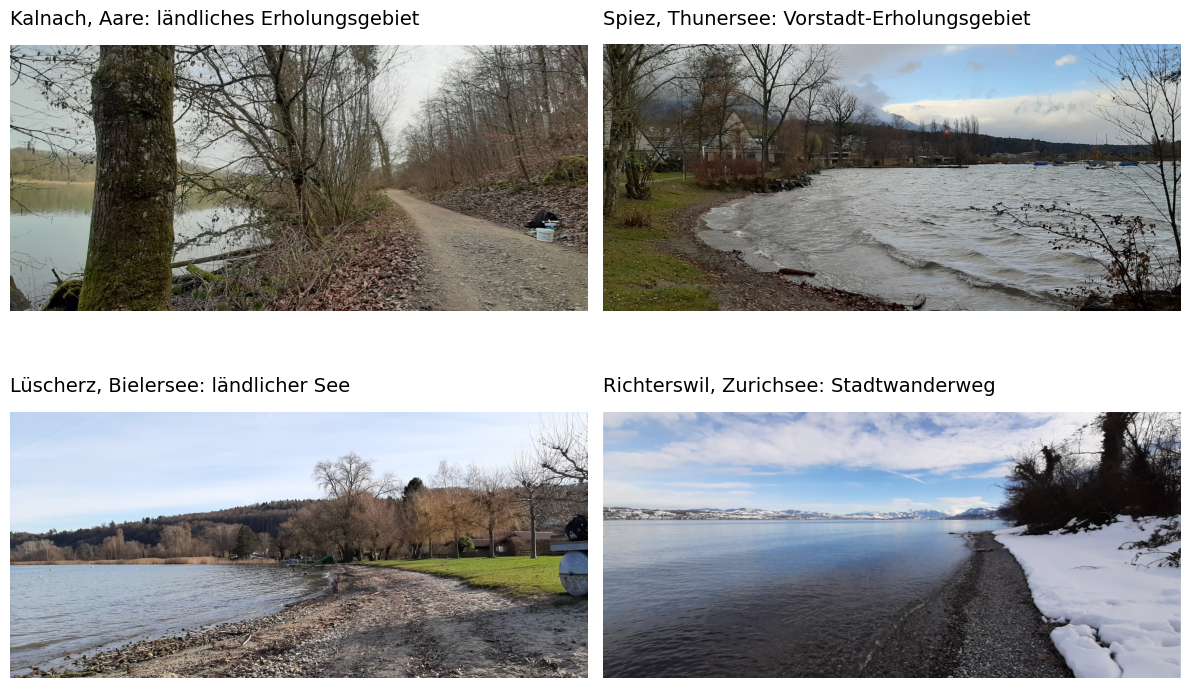

In [4]:
# read images
img_a = mpimg.imread("resources/images/baselines/tightquarterswholensee.jpg")
img_b = mpimg.imread("resources/images/baselines/deltabad.jpg")
img_c = mpimg.imread("resources/images/baselines/lcherz.jpg")
img_d = mpimg.imread("resources/images/baselines/snow.jpg")

# display images
fig, ax = plt.subplots(2,2, figsize=(12,8))

axone=ax[0,0]
sut.hide_spines_ticks_grids(axone)
axone.imshow(img_a);
axone.set_title("Kalnach, Aare: ländliches Erholungsgebiet", **ck.title_k14)

axtwo=ax[0,1]
sut.hide_spines_ticks_grids(axtwo)
axtwo.imshow(img_b);
axtwo.set_title("Spiez, Thunersee: Vorstadt-Erholungsgebiet", **ck.title_k14)

axthree=ax[1,0]
sut.hide_spines_ticks_grids(axthree)
axthree.imshow(img_c);
axthree.set_title("Lüscherz, Bielersee: ländlicher See", **ck.title_k14)

axfour=ax[1,1]
sut.hide_spines_ticks_grids(axfour)
axfour.set_title("Richterswil, Zurichsee: Stadtwanderweg", **ck.title_k14)
axfour.imshow(img_d);

plt.tight_layout()

figure_name = f"types_survey_locations"
types_survey_locations_file_name = f'{save_fig_prefix}{figure_name}.jpeg'

# figure caption
sample_total_notes = [
    "Erhebungsergebnisse und zusammenfassende Statistiken: ",
    "Proben grösser als 10m und ohne Objekte kleiner als 2,5cm und Chemikalien, n=372"
]

types_survey_locations_notes = ''.join(sample_total_notes)

glue("types_survey_locations_notes", types_survey_locations_notes, display=False)


glue("types_survey_locations", fig, display=False)
plt.close()

```{glue:figure} types_survey_locations
:name: "types_survey_locations"


` `

```

{numref}`Abbildung {number}: <types_survey_locations>` Die Datenerhebungen finden in der Stadt, auf dem Land und in der Agglomeration statt.

Die Länge und Breite des Erhebungsgebiets wird bei jeder Datenerhebung gemessen. So kann die Anzahl der Objekte in einer Standardeinheit unabhängig von den Erhebungsorten angegeben werden. In diesem Bericht wird die von der EU empfohlene Standard-Berichtseinheit verwendet: Abfallobjekte pro 100 Meter.

#### Zählen von Objekten 

Alle sichtbaren Objekte innerhalb eines Untersuchungsgebiets werden gesammelt, klassifiziert und gezählt. Das Gesamtgewicht von Material und Plastik wird ebenfalls erfasst. Die Objekte werden anhand von [ Code-Definitionen ](codegroups) klassifiziert, die auf einer Masterliste von Codes in the guide basieren. Spezielle Objekte, die von lokalem Interesse sind, wurden unter G9xx und G7xx hinzugefügt.

In [5]:
p_nine = [
    "Die Länge und Breite des Erhebungsgebiets wird bei jeder Datenerhebung gemessen. ",
    "So kann die Anzahl der Objekte in einer Standardeinheit unabhängig von den Erhebungsorten ",
    "angegeben werden. In diesem Bericht wird die von der EU empfohlene Standard-Berichtseinheit ",
    "verwendet: Abfallobjekte pro 100 Meter."
]

p_nine = makeAParagraph(p_nine)

subsection_four_title = Paragraph("Zählen von Objekten", subsection_title)

p_ten = [
    "Alle sichtbaren Objekte innerhalb eines Untersuchungsgebiets werden gesammelt, ",
    "klassifiziert und gezählt. Das Gesamtgewicht von Material und Plastik wird ",
    "ebenfalls erfasst. Die Objekte werden anhand von ",
    '<a href="https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html" color="blue">Code-Definitionen klassifiziert</a>, ',
    "die auf einer Masterliste von Codes in the guide basieren. Spezielle Objekte, die von lokalem Interesse sind, wurden unter G9xx und G7xx hinzugefügt."
]

p_ten = makeAParagraph(p_ten)

new_components = [
    smallest_space,
    p_nine,
    smallest_space,
    subsection_four_title,
    small_space,
    p_ten,
   
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

```{figure} resources/images/baselines/takingnotes.jpg
---
name: takingnotes
---
` `
```
{numref}`Abbildung %s: <takingnotes>` Zählen und Klassifizieren einer Probe. Die Objekte werden nach dem Sammeln sortiert und gezählt. Die ursprüngliche Zählung wird in einem Notizbuch festgehalten, und die Daten werden in die Anwendung [ plages-propres ](https://www.plagespropres.ch/) eingegeben, wenn der Erheber es wünscht.

## Berechnung der Basislinien 

Die in den Abschnitten 3 und 4 von A European Threshold Value and Assessment Method for Macro litter on Coastlines und den Abschnitten 6, 7 und 8 von Analysis of a pan-European 2012-2016 beach litter data set beschriebenen Methoden werden auf die Ergebnisse der vorliegenden Untersuchung angewendet.

Die verschiedenen Optionen für die Berechnung von Basislinien, die Bestimmung von Konfidenzintervallen und die Identifizierung von Extremwerten werden erläutert und mit Beispielen versehen.

__Annahmen:__

* Je mehr Abfallobjekte auf dem Boden liegen, desto grösser ist die Wahrscheinlichkeit, dass eine Person sie findet.
* Die Erhebungsergebnisse stellen die Mindestmenge an Abfallobjekten an diesem Ort dar.
* Für jede Datenerhebung: Das Auffinden eines Objekts hat keinen Einfluss auf die Wahrscheinlichkeit, ein weiteres zu finden. 

In [6]:
section_two_title = Paragraph("Berechnung der Basislinien", section_title)

p_11 = [
    "Die in den Abschnitten 3 und 4 von A European Threshold Value and Assessment Method ",
    "for Macro litter on Coastlines und den Abschnitten 6, 7 und 8 von Analysis of a ", 
    "pan-European 2012-2016 beach litter data set beschriebenen Methoden werden auf die ",
    "Ergebnisse der vorliegenden Untersuchung angewendet."
]

p_11 = makeAParagraph(p_11)

p_12 = [
    "Die verschiedenen Optionen für die Berechnung von Basislinien, die Bestimmung von ",
    "Konfidenzintervallen und die Identifizierung von Extremwerten werden erläutert und ",
    "mit Beispielen versehen."
]

p_12 = makeAParagraph(p_12)

first_list =[
    "Je mehr Abfallobjekte auf dem Boden liegen, desto grösser ist die Wahrscheinlichkeit, dass eine Person sie findet.",
    "Die Erhebungsergebnisse stellen die Mindestmenge an Abfallobjekten an diesem Ort dar.",
    "Für jede Datenerhebung: Das Auffinden eines Objekts hat keinen Einfluss auf die Wahrscheinlichkeit, ein weiteres zu finden."
]

figure_caption = [
    '<b>Rechts:</b> Zählen und Klassifizieren einer Probe. Die Objekte werden nach dem Sammeln sortiert und gezählt. ',
    "Die ursprüngliche Zählung wird in einem Notizbuch festgehalten, und die Daten werden in die ",
    'Anwendung <a href="https://plagespropres.ch" color="blue"> plagespropres.ch </a> eingegeben, wenn der Erheber es wünscht.'
]

figure_caption = makeAParagraph(figure_caption, style=caption_style)

figure_kwargs.update({
    "image_file":"resources/images/baselines/takingnotes.jpg",
    "original_width":16.05,
    "original_height":12.92,
    "desired_width": 8,
    "caption": None,
})

figure_six = figureAndCaptionTable(**figure_kwargs)


colWidths=[8.2*cm, 8.2*cm]

table_data = [
    [[section_two_title, large_space, figure_caption, smallest_space, p_11], figure_six]
]
figure_six_title = Table(table_data, style=featuredata.side_by_side_style_figure_right, colWidths=colWidths)

the_list_title = Paragraph("Annahmen:", bold_block)
the_first_list = makeAList(first_list)

new_components = [    
    small_space,
    figure_six_title,
    smallest_space,
    p_12,
    smallest_space,
    the_list_title,
    the_first_list,      
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

### Die Daten 

Nur Datenerhebungen mit einer Länge von mehr als zehn Metern und weniger als 100 Metern werden in die Berechnung der Basislinie einbezogen. Die folgenden Objekte wurden ausgeschlossen:

1. Objekte kleiner als 2,5 cm 
2. Paraffin, Wachs, Öl und andere Chemikalien 

'Erhebungsergebnisse und zusammenfassende Statistiken: Proben grösser als 10m und ohne Objekte kleiner als 2,5cm und Chemikalien, n=372'

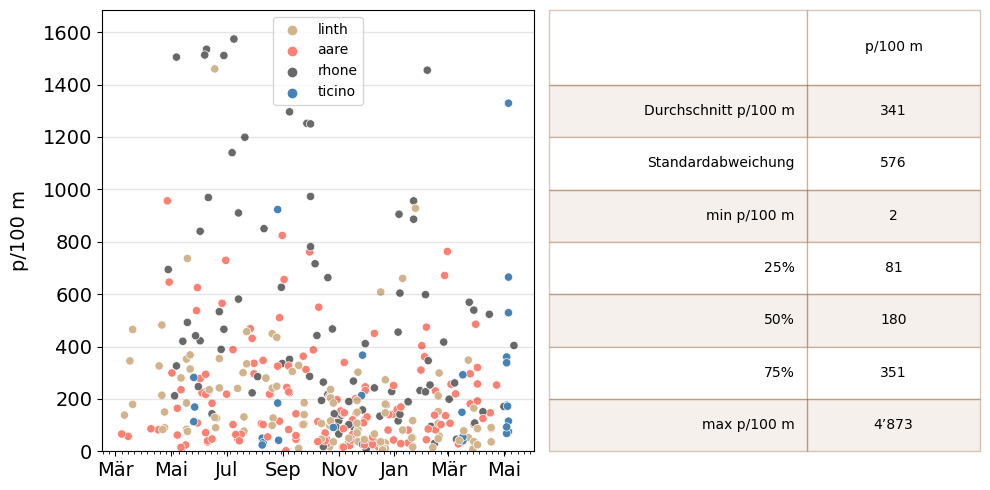

In [7]:
# define the final survey data set here:
a_data = survey_data.copy()

a_data = a_data[a_data.river_bassin != 'les-alpes']

# make a loc_date column from the survey data
# before converting to timestamp
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start - end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# save the data before aggregating to test
before_agg = a_data.copy()

# !! Remove the objects less than 2.5cm and chemicals !!
codes_todrop = ['G81', 'G78', 'G212', 'G213', 'G214']
a_data = a_data[~a_data.code.isin(codes_todrop)]

# use the code groups to get rid of all objects less than 5mm
a_data = a_data[a_data.groupname !=  'micro plastics (< 5mm)']

# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(a_data.location.unique()))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# map the survey area name to the dims data record
a_map = fd_dims[['loc_date', 'area']].set_index('loc_date')
l_map = fd_dims[['loc_date', 'length']].set_index('loc_date')

# map length and area from dims to survey data
for a_survey in fd_dims.loc_date.unique():
    a_data.loc[a_data.loc_date == a_survey, 'length'] = l_map.loc[[a_survey], 'length'][0]
    a_data.loc[a_data.loc_date == a_survey, 'area'] = a_map.loc[[a_survey], 'area'][0]

# exclude surveys less 10 meters or less
gten_lhun = a_data.loc[(a_data.length > 10)].copy()

# this is a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# survey totals by location
dt_all = gten_lhun.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

# palettes and labels
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig = plt.figure(figsize=(10,5))

gs = GridSpec(1,8)

ax = fig.add_subplot(gs[:,0:4])
axtwo = fig.add_subplot(gs[:, 4:])

# scale the chart as needed to accomodate for extreme values
scale_back = 98

# the results gets applied to the y_limit function in the chart
the_90th = np.percentile(dt_all[unit_label], scale_back)

# the survey totals
sns.scatterplot(data=dt_all, x='date', y=unit_label, hue='river_bassin', palette=bassin_pallette, alpha=1, ax=ax)

# set params on ax:
ax.set_ylim(0,the_90th )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
h,l = ax.get_legend_handles_labels()

ax.legend(h, l)

# axtwo
a_color = "dodgerblue"

# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# change the names
csx = sut.change_series_index_labels(cs, featuredata.createSummaryTableIndex(unit_label, language="de"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

sut.hide_spines_ticks_grids(axtwo)

a_table = sut.make_a_table(axtwo, combined_summary[1:],  colLabels=["Stat", unit_label], colWidths=[.6,.4], bbox=[0, 0, 1, 1])
a_table.get_celld()[(0,0)].get_text().set_text(" ")

axtwo.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)
ax.grid(visible=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)

plt.tight_layout()
figure_name = f"baseline_sample_totals"
sample_totals_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":sample_totals_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
sample_total_notes = [
    "Erhebungsergebnisse und zusammenfassende Statistiken: ",
    "Proben grösser als 10m und ohne Objekte kleiner als 2,5cm und Chemikalien, n=372"
]

sample_total_notes = ''.join(sample_total_notes)

glue("baseline_sample_total_notes", sample_total_notes, display=False)


glue("baseline_sample_totals", fig, display=False)
plt.close()

```{glue:figure} baseline_sample_totals
:name: "baseline_sample_totals"
` `
```
{numref}`Abbildung {number}: <baseline_sample_totals>` {glue:text}`baseline_sample_total_notes`

In [8]:
sub_section_one_title = Paragraph("Die Daten", style=subsection_title)

p_13 = [
    "Nur Datenerhebungen mit einer Länge von mehr als zehn Metern und weniger als 100 Metern ",
    "werden in die Berechnung der Basislinie einbezogen. Die folgenden Objekte wurden ausgeschlossen:"
]

p_13 = makeAParagraph(p_13)

data_d_list = [
    "Objekte kleiner als 2,5 cm",
    "Paraffin, Wachs, Öl und andere Chemikalien"
]

baseline_list_one = makeAList(data_d_list)    

fig_7_cap = Paragraph(sample_total_notes, style=caption_style)

figure_kwargs.update({
    "image_file":sample_totals_file_name,
    "original_width":25.4,
    "original_height":12.7,
    "desired_width": 12,
    "caption": fig_7_cap,
})

figure_seven = figureAndCaptionTable(**figure_kwargs)

new_components = [
    small_space,
    sub_section_one_title,
    small_space,
    p_13,
    smallest_space,
    baseline_list_one,
    small_space,    
    figure_seven,
    smallest_space,
  
]
pdfcomponents = addToDoc(new_components, pdfcomponents)

'Verteilung der Datenerhebungen und Perzentilwerte: alle Erhebungen. Beachten Sie, dass der Mittelwert (341p/100m) grösser ist als der Median (180p/100m).'

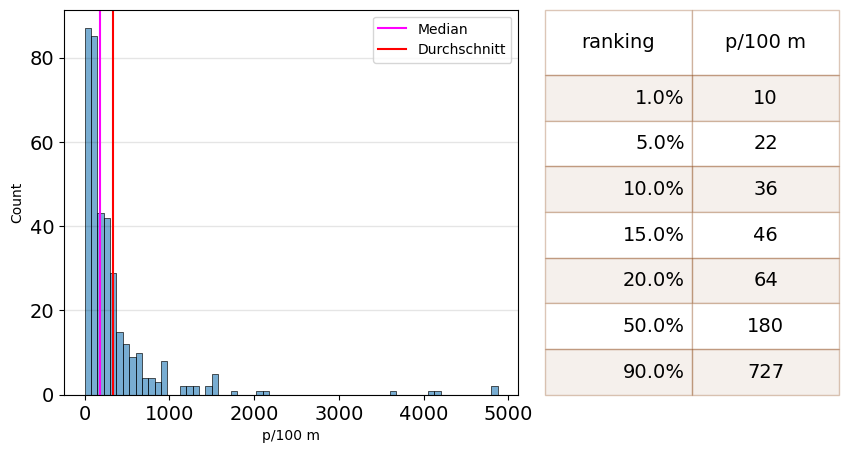

In [9]:
# percentile rankings  1, 5, 10, 15, 20
these_vals = []
for element in [.01,.05,.10,.15,.20, .5, .9 ]:
    a_val = np.quantile(dt_all[unit_label].to_numpy(), element)
    these_vals.append((F"{element*100}%",F"{int(a_val)}"))

fig = plt.figure(figsize=(10,5))

gs = GridSpec(1,5)

ax = fig.add_subplot(gs[:,0:3])
axtwo = fig.add_subplot(gs[:, 3:])
ax.grid(visible=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)

sns.histplot(data=dt_all, x=unit_label, stat='count', ax=ax, alpha=0.6)
ax.axvline(x=dt_all[unit_label].median(), c='magenta', label='Median')
ax.axvline(x=dt_all[unit_label].mean(), c='red', label='Durchschnitt')
ax.legend()

sut.hide_spines_ticks_grids(axtwo)


table_two = sut.make_a_table(axtwo, these_vals, colLabels=('ranking', unit_label), colWidths=[.5,.5], bbox=[0, 0, 1, 1])
table_two.get_celld()[(0,0)].get_text().set_text("ranking")
table_two.set_fontsize(14)

axtwo.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)

figure_name = f"empirical_dist_rankings_baseline"
empirical_dist_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":empirical_dist_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
empirical_dist_notes = [
    "Verteilung der Datenerhebungen und Perzentilwerte: alle Erhebungen. Beachten Sie, dass der ",
    "Mittelwert (341p/100m) grösser ist als der Median (180p/100m)."
]

empirical_dist_notes = ''.join(empirical_dist_notes)

glue("empirical_dist_rankings_baseline_notes", empirical_dist_notes, display=False)


glue("empirical_dist_rankings_baseline", fig, display=False)
plt.close()

```{glue:figure} empirical_dist_rankings_baseline
:name: "empirical_dist_rankings_baseline"


` `

```

{numref}`Abbildung {number}: <empirical_dist_rankings_baseline>` {glue:text}`empirical_dist_rankings_baseline_notes`

### Die Bewertungsmetrik 

Die Berechnung von Basiswerten erfordert die Aggregation von Erhebungsergebnissen auf verschiedenen zeitlichen und geografischen Ebenen. Das ist die beste Methode: 

* Robust in Bezug auf Ausreisser
* Einfach zu berechnen
* Weithin verstanden

Die beiden gebräuchlichsten Teststatistiken, die zum Vergleich von Daten verwendet werden, sind der Mittelwert und der Median. Der Mittelwert ist der beste Prädiktor für die zentrale Tendenz, wenn die Daten ungefähr normal verteilt sind. Die Ergebnisse der Untersuchungen von Strand-Abfallaufkommen weisen jedoch eine hohe Varianz im Verhältnis zum Mittelwert auf. Es können Methoden auf die Daten angewendet werden, um die Auswirkungen der hohen Varianz bei der Berechnung des Mittelwerts zu verringern: 

1. _getrimmter Mittelwert:_ entfernt einen kleinen, festgelegten Prozentsatz der grössten und kleinsten Werte, bevor der Mittelwert berechnet wird 
2. _tri-Mittelwert:_ der gewichtete Durchschnitt des Medians und des oberen und unteren Quartils $(Q1 + 2Q2 + Q3)/4$
3. _mittleres Scharnier:_ $(Q1 + Q3)/2$

Die bisherigen Methoden sind zwar wirksam, um die Auswirkungen von Ausreissern zu reduzieren, aber sie sind nicht so einfach zu berechnen wie der Mittelwert oder der Median, so dass die Signifikanz der Ergebnisse möglicherweise nicht richtig verstanden wird.

Der Median (50. Perzentil) ist ein ebenso guter Prädiktor für die zentrale Tendenz, wird aber im Vergleich zum Mittelwert viel weniger von Extremwerten beeinflusst. Je mehr sich ein Datensatz einer Normalverteilung nähert, desto näher kommen sich Median und Mittelwert. Der Median und die dazugehörigen Perzentil-Funktionen sind in den meisten Tabellenkalkulationsprogrammen verfügbar.

Aus den oben genannten Gründen wird der Medianwert einer Mindestanzahl von Proben, die während eines Probenahmezeitraums in einem Erhebungsgebiet gesammelt wurden, als statistisch geeignet für die Bewertung von Strand-Abfallobjekten angesehen. Für die Meeresumwelt beträgt die Mindestanzahl der Proben 40 pro Unterregion und der Probenahmezeitraum 6 Jahre. {cite}`eubaselines` 

In [10]:
fig_8_cap = Paragraph(empirical_dist_notes, style=caption_style)

figure_kwargs.update({
    "image_file":empirical_dist_file_name,
    "original_width":25.4,
    "original_height":12.7,
    "desired_width": 12,
    "caption": fig_8_cap,
})

figure_eight = figureAndCaptionTable(**figure_kwargs)

subsection_two_title = Paragraph("Die Bewertungsmetrik", subsection_title)
p_14 = [
    "Die Berechnung von Basiswerten erfordert die Aggregation von Erhebungsergebnissen auf verschiedenen z",
    "eitlichen und geografischen Ebenen. Das ist die beste Methode:"
]

p_14 = makeAParagraph(p_14)

baseline_list_three = [
    "Robust in Bezug auf Ausreisser",
    "Einfach zu berechnen",
    "Weithin verstanden"
]

qualities = makeAList(baseline_list_three)

p_15 = [
    "Die beiden gebräuchlichsten Teststatistiken, die zum Vergleich von Daten ",
    "verwendet werden, sind der Mittelwert und der Median. Der Mittelwert ist der ",
    "beste Prädiktor für die zentrale Tendenz, wenn die Daten ungefähr normal verteilt ",
    "sind. Die Ergebnisse der Untersuchungen von Strand-Abfallaufkommen weisen jedoch ",
    "eine hohe Varianz im Verhältnis zum Mittelwert auf. Es können Methoden auf die Daten ",
    "angewendet werden, um die Auswirkungen der hohen Varianz bei der Berechnung des ",
    "Mittelwerts zu verringern:"
]

p_15 = makeAParagraph(p_15)

baseline_list_four = [
    "<i>getrimmter Mittelwert:</i> entfernt einen kleinen, festgelegten Prozentsatz der grössten und kleinsten Werte, bevor der Mittelwert berechnet wird",
    "<i>tri-Mittelwert: </i> der gewichtete Durchschnitt des Medians und des oberen und unteren Quartils (Q1 + 2Q2 + Q3)/4",
    "<i>Mittelscharnier: (Q1 + Q3)/2</i>",
]

methods = makeAList(baseline_list_four)

p_16 = [
    "Die bisherigen Methoden sind zwar wirksam, um die Auswirkungen von Ausreissern zu reduzieren, ",
    "aber sie sind nicht so einfach zu berechnen wie der Mittelwert oder der Median, so dass die ",
    "Signifikanz der Ergebnisse möglicherweise nicht richtig verstanden wird."
]

p_17 = [
    "Der Median (50. Perzentil) ist ein ebenso guter Prädiktor für die zentrale Tendenz, wird aber im ",
    "Vergleich zum Mittelwert viel weniger von Extremwerten beeinflusst. Je mehr sich ein Datensatz ",
    "einer Normalverteilung nähert, desto näher kommen sich Median und Mittelwert. Der Median und die ",
    "dazugehörigen Perzentil-Funktionen sind in den meisten Tabellenkalkulationsprogrammen verfügbar."
]

p_18 = [
    "Aus den oben genannten Gründen wird der Medianwert einer Mindestanzahl von Proben, die während ",
    "eines Probenahmezeitraums in einem Erhebungsgebiet gesammelt wurden, als statistisch geeignet ",
    "für die Bewertung von Strand-Abfallobjekten angesehen. Für die Meeresumwelt beträgt die Mindestanzahl ",
    'der Proben 40 pro Unterregion und der Probenahmezeitraum 6 Jahre.<a href="#HG19" color="blue">(HG19)</a>'
]

p_16_to_18 = sectionParagraphs([p_16, p_17, p_18], smallspace=smallest_space)

new_components = [
    figure_eight,
    smallest_space,
    subsection_two_title,
    small_space,
    p_14,
    smallest_space,
    qualities,
    smallest_space,
    p_15,
    smallest_space,
    methods,
    *p_16_to_18,  
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

### Konfidenzintervalle (KIs) 

Konfidenzintervalle (KIs) helfen dabei, die Unsicherheit der Ergebnisse von Strand-Abfallobjekten im Hinblick auf allgemeine Schlussfolgerungen über die Häufigkeit von Strand-Abfallobjekten in einer Region zu vermitteln. Das KI gibt den unteren und oberen Bereich der Schätzung der Teststatistik angesichts der Stichprobendaten an. 

Der beste Weg, die Unsicherheit zu verringern, ist eine angemessene Anzahl von Proben für die Region oder das Gebiet von Interesse zu erheben. Strand-Abfallerhebungen weisen jedoch eine hohe Varianz auf und jede Schätzung eines Gesamtwerts sollte diese Varianz oder Unsicherheit widerspiegeln. kIs geben einen wahrscheinlichen Wertebereich angesichts der Unsicherheit/Varianz der Daten an.{cite}`eubaselines`

Bei dieser Methode werden die Daten NICHT von den Basisberechnungen und Konfidenzintervallen ausgeschlossen.

> Man einigte sich darauf, die extremen Ergebnisse im Datensatz zu belassen, gleichzeitig aber die Notwendigkeit zu betonen, extreme Daten von Fall zu Fall zu überprüfen und den Median für die Berechnung von Durchschnittswerten zu verwenden. Auf diese Weise können alle Daten verwendet werden, ohne dass die Ergebnisse durch einzelne aussergewöhnlich hohe Abfallaufkommen verzerrt werden. {cite}`threshholdeu`

#### Bootstrap-Methoden: 
Bootstrapping ist eine Methode zur Wiederholung von Stichproben, bei der Zufallsstichproben mit Ersetzung verwendet werden, um den Stichprobenprozess zu wiederholen oder zu simulieren. Bootstrapping ermöglicht die Schätzung der Stichprobenverteilung von Stichprobenstatistiken unter Verwendung von Zufallsstichprobenverfahren. {cite}`bootstrapdef` {cite}`bsci` {cite}`usingbootstrap`

Bootstrap-Methoden werden verwendet, um das KI der Teststatistiken zu berechnen, indem der Stichprobenprozess wiederholt wird und der Median bei jeder Wiederholung ausgewertet wird. Der Wertebereich, der durch die mittleren 95 % der Bootstrap-Ergebnisse beschrieben wird, ist das KI für die beobachtete Teststatistik. 

Es stehen mehrere Berechnungsmethoden zur Auswahl, z. B. Perzentil, BCa und Student’s t. Für dieses Beispiel wurden zwei Methoden getestet: 

1. Perzentil-Bootstrap
2. Bias-korrigiertes beschleunigtes Bootstrap-Konfidenzintervall (BCa) 

Die Perzentil-Methode berücksichtigt nicht die Form der zugrundeliegenden Verteilung, was zu Konfidenzintervallen führen kann, die nicht mit den Daten übereinstimmen. Die Bca-Methode korrigiert dies. Die Implementierung dieser Methoden ist mit den bereits zitierten Paketen einfach zu bewerkstelligen. {cite}`bcatheory` {cite}`bcaimpdrysdale` {cite}`bcaconfidence`

### Vergleich der Bootstrap-KIs 

In [11]:
subsection_ki = Paragraph("Konfidenzintervalle (KIs)", subsection_title)

p_19 = [
    "Konfidenzintervalle (KIs) helfen dabei, die Unsicherheit der Ergebnisse von ",
    "Strand-Abfallobjekten im Hinblick auf allgemeine Schlussfolgerungen über die ",
    "Häufigkeit von Strand-Abfallobjekten in einer Region zu vermitteln. Das KI gibt ",
    "den unteren und oberen Bereich der Schätzung der Teststatistik angesichts der Stichprobendaten an."
]

p_20 = [
    "Der beste Weg, die Unsicherheit zu verringern, ist eine angemessene Anzahl von Proben für ",
    "die Region oder das Gebiet von Interesse zu erheben. Strand-Abfallerhebungen weisen ",
    "jedoch eine hohe Varianz auf und jede Schätzung eines Gesamtwerts sollte diese Varianz ",
    "oder Unsicherheit widerspiegeln. kIs geben einen wahrscheinlichen Wertebereich angesichts ",
    'der Unsicherheit/Varianz der Daten an. <a href="#HG19" color="blue">(HG19)</a>'
]

p_21 = [
    "Bei dieser Methode werden die Daten NICHT von den Basisberechnungen und Konfidenzintervallen ausgeschlossen."
]

p_22 = [
    '"Man einigte sich darauf, die extremen Ergebnisse im Datensatz zu belassen, gleichzeitig aber die ',
    "Notwendigkeit zu betonen, extreme Daten von Fall zu Fall zu überprüfen und den Median für die Berechnung ",
    "von Durchschnittswerten zu verwenden. Auf diese Weise können alle Daten verwendet werden, ohne dass die ",
    'Ergebnisse durch einzelne aussergewöhnlich hohe Abfallaufkommen verzerrt werden". <a href="#VLW20" color="blue">(VLW20)</a>'
]
        
p_22 = ''.join(p_22)

p_22 = Paragraph(p_22, block_quote_style)

p_19_to_21 = sectionParagraphs([p_19, p_20, p_21], smallspace=smallest_space)

subsection_boot = Paragraph("Bootstrap-Methoden:", subsection_title)

p_23 = [
    "Bootstrapping ist eine Methode zur Wiederholung von Stichproben, bei der Zufallsstichproben ",
    "mit Ersetzung verwendet werden, um den Stichprobenprozess zu wiederholen oder zu simulieren. ",
    "Bootstrapping ermöglicht die Schätzung der Stichprobenverteilung von Stichprobenstatistiken unter",
    "Verwendung von Zufallsstichprobenverfahren.",
    '<a href="#Wika" color="blue">(Wika)</a><a href="#JLGC19" color="blue">(JLGC19)</a><a href="#Sta21b" color="blue">(Sta21b)</a>'
]

p_24 = [
    "Bootstrap-Methoden werden verwendet, um das KI der Teststatistiken zu berechnen, indem der ",
    "Stichprobenprozess wiederholt wird und der Median bei jeder Wiederholung ausgewertet wird. ",
    "Der Wertebereich, der durch die mittleren 95 % der Bootstrap-Ergebnisse beschrieben wird, ",
    "ist das KI für die beobachtete Teststatistik."
]

p_25 = [
    "Es stehen mehrere Berechnungsmethoden zur Auswahl, z. B. Perzentil, BCa und Student’s t. ",
    "Für dieses Beispiel wurden zwei Methoden getestet:"
]

p_23_to_25 = sectionParagraphs([p_23, p_24, p_25], smallspace=smallest_space)

p_26 = [
    "Perzentil-Bootstrap",
    "Bias-korrigiertes beschleunigtes Bootstrap-Konfidenzintervall (Bca)"
]

p_26 = makeAList(p_26)


p_27 = [
    "Die Perzentil-Methode berücksichtigt nicht die Form der zugrundeliegenden Verteilung, ",
    "was zu Konfidenzintervallen führen kann, die nicht mit den Daten übereinstimmen. Die Bca-Methode ",
    "korrigiert dies. Die Implementierung dieser Methoden ist mit den bereits zitierten Paketen ",
    "einfach zu bewerkstelligen.",
    '<a href="#Efr87" color="blue">(Efr87)</a><a href="#dry20" color="blue">(dry20)</a><a href="#Boi19" color="blue">(Boi19)</a>'
]

p_27 = makeAParagraph(p_27)
    

# references
wikapub = 'Bootstrapping. wikipedia https://en.wikipedia.org/wiki/Bootstrapping_(statistics).'

wika = makeAParagraph(featuredata.makeBibEntry(name="Wika", team="Wikipedia", pub=wikapub))

jlgc_team = "Kwanghee Jung, Jaehoon Lee, Vibhuti Gupta, and Gyeongcheol Cho."
jlgcpub = [
    "Comparison of bootstrap confidence interval methods for gsca using a monte carlo simulation. ",
    "Frontiers in Psychology, 10:2215, 2019. URL: ",
    'https://www.frontiersin.org/article/10.3389/fpsyg.2019.02215, doi:10.3389/fpsyg.2019.02215'
]
jlgcpub = ''.join(jlgcpub)

jlgc19 = makeAParagraph(featuredata.makeBibEntry(name="JLGC19", team=jlgc_team, pub=jlgcpub))


sta21bpub = [
    "Is it true that the percentile bootstrap should never be used? 2021. URL: ",
    'https://stats.stackexchange.com/questions/355781/is-it-true-that-the-percentile-bootstrap-should-never-be-used'
]

sta21pub = ''.join(sta21bpub)

sta21b = makeAParagraph(featuredata.makeBibEntry(name="Sta21b", team="Stackexchange", pub=sta21pub))

efr87pub = [
    "Better bootstrap confidence intervals. Journal of the American ",
    "Statistical Association, 82(397):171–185, 1987. URL: ",
    'https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478410, doi:10.1080/01621459.1987.10478410'
]

efr87pub = ''.join(efr87pub)

efr87 = makeAParagraph(featuredata.makeBibEntry(name="Efr87", team="Bradley Efron", pub=efr87pub))

dry20pub = [
    "Implementing the bias-corrected and ",
    "accelerated bootstrap in python. 2020. URL: ",
    'https://www.erikdrysdale.com/bca_python/'
]

dry20pub = ''.join(dry20pub)

dry20 = makeAParagraph(featuredata.makeBibEntry(name="dry20", team="Erik Drysdale", pub=dry20pub))

boi19pub = [
    "Introduction to data analysis in the biological sciences. 2019.",
    'http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/index.html#'
    
]
boi19pub = ''.join(boi19pub)

boi19 = makeAParagraph(featuredata.makeBibEntry(name="Boi19", team="Justin Bois", pub=boi19pub))

references = [*references, smallest_space,wika, smallest_space, jlgc19, smallest_space, sta21b, smallest_space, efr87, smallest_space, dry20, smallest_space, boi19]

new_components = [
    smallest_space,
    subsection_ki,
    small_space,
    *p_19_to_21,
    p_22,
    smallest_space,
    subsection_boot,
    small_space,
    *p_23_to_25,
    p_26,
    smallest_space,
    p_27,    
   
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

'Konfidenzintervalle, die durch eine 5.000-fache Wiederholungsstichprobe der Umfrageergebnisse für jede Bedingung berechnet wurden'

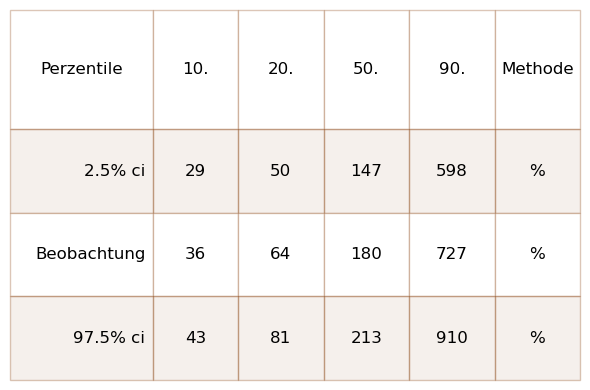

In [12]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)

quantiles = [.1, .2, .5, .9]
q_vals = {x:dt_all[unit_label].quantile(x) for x in quantiles}

the_bcas = {}
for a_rank in quantiles:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
    observed = np.percentile(dt_all[unit_label].to_numpy(), an_int)
    the_bcas.update({F"{int(a_rank*100)}":{'2.5% ci':a_result[0], "Beobachtung": observed, '97.5% ci': a_result[1]}})


bca_cis = pd.DataFrame(the_bcas)
bcas = bca_cis.reset_index()
bcas[['10', '20', '50', '90']] = bcas[['10', '20', '50', '90']].astype('int')
bcas['b-method'] = 'BCa'

# bootstrap percentile confidence intervals
# resample the survey totals for n times to help
# define the range of the sampling statistic
# the number of reps
n=5000

# keep the observed values
observed_median = dt_all[unit_label].median()
observed_tenth = dt_all[unit_label].quantile(.15)

the_cis = {}

for a_rank in quantiles:
    # for the median
    sim_ptile = []

    # for the tenth percentile
    sim_ten = []
    for element in np.arange(n):
        less = dt_all[unit_label].sample(n=len(dt_all), replace=True)    
        a_ptile = less.quantile(a_rank)
        sim_ptile.append(a_ptile)
    # get the upper and lower range of the test statistic disrtribution:
    a_min = np.percentile(sim_ptile, 2.5)
    a_max = np.percentile(sim_ptile, 97.5)
    
    # add the observed value and update the dict
    the_cis.update({F"{int(a_rank*100)}":{'2.5% ci':a_min, "Beobachtung": q_vals[a_rank], '97.5% ci': a_max}})

# make df
p_cis = pd.DataFrame(the_cis)
p_cis = p_cis.astype("int")
p_cis['b-method'] = '%'
p_cis.reset_index(inplace=True)

fig, axs = plt.subplots(figsize=(6,4))

axone = axs


data = p_cis.values
sut.hide_spines_ticks_grids(axone)

colLabels = [F"{x}." for x in p_cis.columns[:-1]]
colLabels.append('Methode')

table_one = sut.make_a_table(axone, data, colLabels=colLabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])


table_one.set_fontsize(12)

                        
table_one.get_celld()[(0,0)].get_text().set_text("Perzentile")


plt.tight_layout()

figure_name = f"ci_percentile_bootstrap"
ci_percentile_bootstrap_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":ci_percentile_bootstrap_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
ci_percentile_bootstrap_notes = [
    "Konfidenzintervalle, die durch eine 5.000-fache Wiederholungsstichprobe der ",
    "Umfrageergebnisse für jede Bedingung berechnet wurden"
]

ci_percentile_bootstrap_notes = ''.join(ci_percentile_bootstrap_notes)

glue("ci_percentile_bootstrap_notes", ci_percentile_bootstrap_notes, display=False)

glue("ci_percentile_bootstrap", fig, display=False)

plt.close()

```{glue:figure} ci_percentile_bootstrap
:name: "ci_percentile_bootstrap"


` `

```

{numref}`Abbildung {number}: <ci_percentile_bootstrap>` {glue:text}`ci_percentile_bootstrap_notes`

'Die gleichen Intervalle unter Verwendung der verzerrungskorrigierten Methode.'

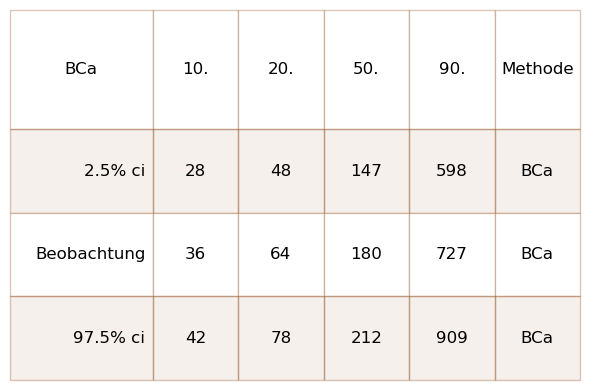

In [13]:
fig, axs = plt.subplots(figsize=(6,4))

axtwo = axs

data = p_cis.values
sut.hide_spines_ticks_grids(axtwo)
colLabels = [F"{x}." for x in p_cis.columns[:-1]]
colLabels.append('Methode')

table_two = sut.make_a_table(axtwo, bcas.values, colLabels=colLabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

table_two.set_fontsize(12)    
                        
table_two.get_celld()[(0,0)].get_text().set_text("BCa")

plt.tight_layout()

figure_name = f"bca_bootstrap"
bca_bootstrap_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":bca_bootstrap_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
bca_bootstrap_notes = [
    "Die gleichen Intervalle unter Verwendung der verzerrungskorrigierten Methode."
]

bca_bootstrap_notes = ''.join(bca_bootstrap_notes)

glue("bca_bootstrap_notes", bca_bootstrap_notes, display=False)


glue("bca_bootstrap", fig, display=False)
plt.close()

```{glue:figure} bca_bootstrap
:name: "bca_bootstrap"


` `

```

{numref}`Abbildung {number}: <bca_bootstrap>` {glue:text}`bca_bootstrap_notes`

```{figure} resources/images/baselines/mullermatte_bielersee31_01_2021.png
:name: mullermatte_bielersee31_01_2021


` `

```

{numref}`Abbildung {number}: <mullermatte_bielersee31_01_2021>` Beispiel für das Konfidenzintervall: Das Ergebnis der Datenerhebungen in Biel am 31.01.2021 war grösser als der Medianwert für alle Datenerhebungen. Es wurden 123 Objekte (p) über 40 Meter (m) Uferlinie gesammelt. Zunächst wird der Wert der Datenerhebungen in Abfallobjekte pro Meter (p/m) umgerechnet und dann mit der erforderlichen Anzahl von Metern (100) multipliziert: $(pcs/m)*100 = (123_{pcs} / 40_m)*100 m \approxeq \text{313 p/100 m}$

In [14]:
subsection_kis_two = Paragraph("Vergleich der Bootstrap-KIs", style=subsection_title)

fig_9_cap = Paragraph(bca_bootstrap_notes, style=caption_style)

figure_kwargs.update({
    "image_file":bca_bootstrap_file_name,
    "original_width":15.24,
    "original_height":10.16,
    "desired_width": 7.9,
    "caption": fig_9_cap,
    "caption_height": 1.5,
})

figure_nine = figureAndCaptionTable(**figure_kwargs)

fig_10_cap = Paragraph(ci_percentile_bootstrap_notes, style=caption_style)
figure_kwargs.update({
    "image_file":ci_percentile_bootstrap_file_name,
    "original_width":15.24,
    "original_height":10.16,
    "desired_width": 7.9,
    "caption": fig_10_cap,
})

figure_ten = figureAndCaptionTable(**figure_kwargs)

table_data = [[figure_nine, figure_ten]]

fig_nine_ten = Table(table_data, colWidths=[8.5*cm, 8.5*cm])                      

new_components = [
    smallest_space,
    subsection_kis_two,
    small_space,
    fig_nine_ten,
   
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

### Basiswerte 

Für diesen Datensatz sind die Unterschiede zwischen den mit der Bca-Methode oder der Perzentilmethode berechneten KIs minimal. Die Bca-Methode wird verwendet, um die Basiswerte und KIs anzugeben.

#### Basismedianwert aller Erhebungsergebnisse 

Wenn man nur Datenerhebungen mit einer Länge von mehr als 10 Metern berücksichtigt und Objekte mit einer Grösse von weniger als 2,5 cm ausschliesst, __lag der Medianwert aller Daten bei 181 p/100 m mit einem KI von 147 p/100 m – 213 p/100 m. Der gemeldete Medianwert für die EU lag bei 133 p/100 m__ und damit im Bereich des KI der IQAASL-Erhebungsergebnisse. Während der Medianwert in der Schweiz höher ist, liegt der Mittelwert der EU-Studie bei 504 p/100 m gegenüber 341 p/100 m in der Schweiz.{cite}`eubaselines`

Das deutet darauf hin, dass die höheren Extremwerte in der Meeresumwelt wahrscheinlicher waren, aber der erwartete Medianwert beider Datensätze ist ähnlich. 

#### Median-Basislinie und KI pro Erhebungsgebiet 

In der vorliegenden Studie wurden in drei von vier Erhebungsgebieten mehr als 40 Erhebungen durchgeführt.

'Der Median und das 95-Prozent-Konfidenzintervall der Erhebungsgebiete Linth, Aare und Rhône. Das Erhebungsgebiet Tessin ist mangels ausreichender Anzahl von Datenerhebungen nicht enthalten.'

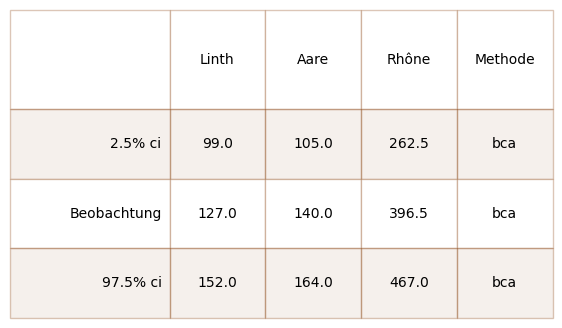

In [15]:
bassins = ["linth", "aare", "rhone"]
the_sas = {}
for a_bassin in bassins:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=50)
    observed = np.percentile(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), 50)
    the_sas.update({a_bassin:{'2.5% ci':a_result[0], "Beobachtung": observed, '97.5% ci': a_result[1]}})

sas = pd.DataFrame(the_sas)

new_colnames = {
    "linth":"Linth",
    "rhone": "Rhône",
    "aare":"Aare",
    "b-method": "Methode"
}
sas['b-method'] = 'bca'
sas.rename(columns=new_colnames, inplace=True)
sas = sas.reset_index()


    

fig, axs = plt.subplots(figsize=(7,4))

data = sas.values
sut.hide_spines_ticks_grids(axs)

table_one = sut.make_a_table(axs, data, colLabels=sas.columns, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])
table_one.get_celld()[(0,0)].get_text().set_text(" ")

figure_name = "ci_survey_area"
ci_survey_area_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":ci_survey_area_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
ci_survey_area_notes = [
    "Der Median und das 95-Prozent-Konfidenzintervall der Erhebungsgebiete Linth, Aare ",
    "und Rhône. Das Erhebungsgebiet Tessin ist mangels ausreichender Anzahl von Datenerhebungen ",
    "nicht enthalten."
]

ci_survey_area_notes = ''.join(ci_survey_area_notes)

glue("ci_survey_area_notes", ci_survey_area_notes, display=False)

glue("ci_survey_area", fig, display=False)

plt.close()

```{glue:figure} ci_survey_area
---
name: 'ci_survey_area'
---
` `
```
{numref}`Abbildung %s: <ci_survey_area>` {glue:text}`ci_survey_area_notes`

In [16]:
fig_11_caption = [
    "<b>Rechts:</b> Beispiel für das Konfidenzintervall: Das Ergebnis der Datenerhebungen in Biel am 31.01.2021 war grösser als der Medianwert ",
    "für alle Datenerhebungen. Es wurden 123 Objekte (p) über 40 Meter (m) Uferlinie gesammelt. Zunächst wird der Wert der ",
    "Datenerhebungen in Abfallobjekte pro Meter (p/m) umgerechnet und dann mit der erforderlichen Anzahl von Metern (100) multipliziert: ",
    "(p/m)*100 = (123_{p} / 40_m)*100 m ≈313 p/100 m"
]

fig_11_caption = ''.join(fig_11_caption)

fig_11_caption = Paragraph(fig_11_caption, style=caption_style)
figure_kwargs.update({
    "image_file":"resources/images/baselines/mullermatte_bielersee31_01_2021.png",
    "original_width":20.8,
    "original_height":15.4,
    "desired_width": 7.9,
    "caption": None,
})

figure_11 = figureAndCaptionTable(**figure_kwargs)

subsection_survey_area_baselines = Paragraph("Basiswerte", subsection_title)

p_28 = [
    "Für diesen Datensatz sind die Unterschiede zwischen den mit der ",
    "Bca-Methode oder der Perzentilmethode berechneten KIs minimal. ",
    "Die Bca-Methode wird verwendet, um die Basiswerte und KIs anzugeben."
]

p_28= makeAParagraph(p_28)

bold_header_cis = Paragraph("Basismedianwert aller Erhebungsergebnisse", style=bold_block)

p_29 = [
    "Wenn man nur Datenerhebungen mit einer Länge von mehr als 10 Metern berücksichtigt ",
    "und Objekte mit einer Grösse von weniger als 2,5 cm ausschliesst, <b>lag der Medianwert ",
    "aller Daten bei 181 p/100 m mit einem KI von 147 p/100 m – 213 p/100 m. Der gemeldete ",
    "Medianwert für die EU lag bei 133 p/100 m</b> und damit im Bereich des KI der ",
    "IQAASL-Erhebungsergebnisse. Während der Medianwert in der Schweiz höher ist, liegt der ",
    "Mittelwert der EU-Studie bei 504 p/100 m gegenüber 341 p/100 m in der Schweiz."
]

p_30 = [
    "Das deutet darauf hin, dass die höheren Extremwerte in der Meeresumwelt wahrscheinlicher ",
    "waren, aber der erwartete Medianwert beider Datensätze ist ähnlich."
]

p_29_to_30 = sectionParagraphs([p_29, p_30], smallspace=smallest_space)

bold_header_survey_area_cis = Paragraph("Median-Basislinie und KI pro Erhebungsgebiet", style=bold_block)

p_31 = [
    "In der vorliegenden Studie wurden in drei von vier Erhebungsgebieten mehr als 40 Erhebungen durchgeführt."
]

p_31 = makeAParagraph(p_31)

table_data = [[[subsection_survey_area_baselines, small_space, p_28, smallest_space, fig_11_caption], figure_11]]

baseline_title_figure = Table(table_data, style=featuredata.side_by_side_style_figure_right, colWidths=[8.3*cm, 8.3*cm])

fig_12_caption = ''.join(ci_survey_area_notes)

fig_12_caption = f'<b>Links:</b> {fig_12_caption}'

fig_12_caption = Paragraph(fig_12_caption, style=caption_style)
figure_kwargs.update({
    "image_file":ci_survey_area_file_name,
    "original_width":17.78,
    "original_height":10.16,
    "desired_width": 7.9,
    "caption": None,
})

figure_12 = figureAndCaptionTable(**figure_kwargs)

table_data =  [[figure_12, [bold_header_survey_area_cis, smallest_space, p_31, smallest_space, fig_12_caption]]]
survey_area_cis = Table(table_data, colWidths=[8.3*cm, 8.3*cm], style=featuredata.side_by_side_style_figure_left)         

new_components = [
    small_space,
    baseline_title_figure,
    smallest_space,
    bold_header_survey_area_cis,
    smallest_space,
    *p_29_to_30,
    survey_area_cis,
    
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

## Extremwerte 

Wie bereits erwähnt, werden Extremwerte (EVs) oder Ausreisser bei der Berechnung von Basislinien oder CIs nicht aus den Daten ausgeschlossen. Die Identifizierung von EVs und wo und wann sie auftreten, ist jedoch ein wesentlicher Bestandteil des Überwachungsprozesses. 

Das Auftreten von Extremwerten kann den Durchschnitt der Daten und die Interpretation der Erhebungsergebnisse beeinflussen. Laut dem GFS-Bericht:

>  Die Methodik zur Identifizierung von Extremwerten kann entweder auf einem Expertenurteil beruhen oder auf statistischen und modellierenden Ansätzen, wie der Anwendung von Tukey's Box Plots zur Erkennung potenzieller Ausreisser. Für schiefe Verteilungen ist der angepasste Boxplot besser geeignet. {cite}`eubaselines`

### Extremwerte definieren

Die Referenzen geben keine Hinweise auf den numerischen Wert eines EV. Im Gegensatz zu dem Zielwert von 20 p/100 m oder dem 15. Perzentil bleibt die Definition eines EV der Person überlassen, die die Daten interpretiert. Die Obergrenze von Tukeys Boxplot (unangepasst) ist ungefähr das 90. Perzentil der Daten. Diese Methode ist mit der Bewertungsmetrik kompatibel, und Boxplots lassen sich visuell relativ leicht auflösen.

#### Angepasste Boxplots 

Tukeys Boxplot wird verwendet, um die Verteilung eines univariaten Datensatzes zu visualisieren. Die Proben, die innerhalb des ersten Quartils (25 %) und des dritten Quartils (75 %) liegen, werden als innerhalb des inneren Quartilsbereichs (IQR) betrachtet. Punkte, die ausserhalb des inneren Quartils liegen, werden als Ausreisser betrachtet, wenn ihr Wert grösser oder kleiner als einer der beiden Grenzwerte ist:

* Untere Grenze =   $Q_1 - (1.5*IQR)$
* Obergrenze =   $Q_3 + (1.5*IQR)$

Die Grenzen werden erweitert oder reduziert, um der Form der Daten besser zu entsprechen. Infolgedessen repräsentieren die oberen und unteren Grenzen einen grösseren Wertebereich in Bezug auf das Perzentil-Ranking als bei der unangepassten Version.{cite}`tukeysbox` {cite}`medcouple` 

Die neue Berechnung sieht wie folgt aus: 

* Untere Grenze = $Q_1 - (1.5e^{-4MC}*IQR)$

* Obergrenze = $Q_3 + (1.5e^{3MC}*IQR)$

Die Grenzen werden erweitert oder reduziert, um der Form der Daten besser zu entsprechen. Infolgedessen repräsentieren die oberen und unteren Grenzen einen grösseren Wertebereich in Bezug auf das Perzentil-Ranking als bei der unangepassten Version.

In [17]:
extreme_section = Paragraph("Extremewerte", section_title)
p_32 = [
    "Wie bereits erwähnt, werden Extremwerte (EVs) oder Ausreisser bei der Berechnung ",
    "von Basislinien oder CIs nicht aus den Daten ausgeschlossen. Die Identifizierung ",
    "von EVs und wo und wann sie auftreten, ist jedoch ein wesentlicher Bestandteil des ",
    "Überwachungsprozesses."
]

p_33 = [
    "Das Auftreten von Extremwerten kann den Durchschnitt der Daten und die Interpretation ",
    "der Erhebungsergebnisse beeinflussen. Laut dem GFS-Bericht:"
]

p_32_to_33 = sectionParagraphs([p_32, p_33], smallspace=smallest_space)

p_34 = [
    "Die Methodik zur Identifizierung von Extremwerten kann entweder auf einem ",
    "Expertenurteil beruhen oder auf statistischen und modellierenden Ansätzen, wie",
    "der Anwendung von Tukey's Box Plots zur Erkennung potenzieller Ausreisser. Für ",
    "schiefe Verteilungen ist der angepasste Boxplot besser geeignet.",
    '<a href="#HG19" color="blue">(HG19)</a>'
]

p_34 = makeAParagraph(p_34, style=block_quote_style)

extreme_def = Paragraph("Extremwerte definieren", style=subsection_title)

p_35 = [
    "Die Referenzen geben keine Hinweise auf den numerischen Wert eines EV. Im Gegensatz zu dem ",
    "Zielwert von 20 p/100 m oder dem 15. Perzentil bleibt die Definition eines EV der Person ",
    "überlassen, die die Daten interpretiert. Die Obergrenze von Tukeys Boxplot (unangepasst) ",
    "ist ungefähr das 90. Perzentil der Daten. Diese Methode ist mit der Bewertungsmetrik ",
    "kompatibel, und Boxplots lassen sich visuell relativ leicht auflösen."
]

p_35 = makeAParagraph(p_35)

boxplots_def = Paragraph("Angepasste Boxplots", style=subsection_title)


p_36 = [
    "Tukeys Boxplot wird verwendet, um die Verteilung eines univariaten Datensatzes ",
    "zu visualisieren. Die Proben, die innerhalb des ersten Quartils (25 %) und des dritten ",
    "Quartils (75 %) liegen, werden als innerhalb des inneren Quartilsbereichs (IQR) betrachtet. ",
    "Punkte, die ausserhalb des inneren Quartils liegen, werden als Ausreisser betrachtet, ",
    "wenn ihr Wert grösser oder kleiner als einer der beiden Grenzwerte ist:"
]

p_36 = makeAParagraph(p_36)

tukeys_normal = [
    "Untere Grenze = Q_1 - (1.5*IQR)",
    "Obergrenze = Q_3 + (1.5*IQR)"
]

tukeys_normal = makeAList(tukeys_normal)

p_37 = [
    "Bei der Anpassung des Boxplots wird die Konstante 1,5 durch einen anderen Parameter ",
    "ersetzt. Dieser Parameter wird mit einer Methode namens Medcouple (MC) berechnet und ",
    "das Ergebnis dieser Methode auf die Konstante 1,5 angewendet.",
    '<a href="#HV08" color="blue">(HV08)</a><a href="#SP" color="blue">(SP)</a>'
]

p_37 = makeAParagraph(p_37)

medcouple_header = Paragraph("Die neue Berechnung sieht wie folgt aus:", style=featuredata.p_style)

medcouple_list = [
    "Untere Grenze = Q_1 - (1.5e^{-4MC}*IQR)",
    "Obergrenze = Q_3 + (1.5e^{3MC}*IQR)",
]

medcouple_list = makeAList(medcouple_list)

p_38 = [
    "Die Grenzen werden erweitert oder reduziert, um der Form der Daten besser zu entsprechen. ",
    "Infolgedessen repräsentieren die oberen und unteren Grenzen einen grösseren Wertebereich ",
    "in Bezug auf das Perzentil-Ranking als bei der unangepassten Version."
]

p_38 = makeAParagraph(p_38)

spbib = [
    "Statsmodels: econometric and statistical modeling with python. URL: ",
    "https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.medcouple.html."
]
spbib = ''.join(spbib)

spmodel = makeAParagraph(featuredata.makeBibEntry(name="SP", team="Skipper Seabold and Josef Perktold", pub=spbib))

hvo8pub = [
    "An adjusted boxplot for skewed distributions. Computational Statistics & Data Analysis, ",
    "52:5186–5201, 08 2008. doi:10.1016/j.csda.2007.11.008."
]
hvo8pub = ''.join(hvo8pub)

hv08 = makeAParagraph(featuredata.makeBibEntry(name="HV08", team="Mia Hubert and Ellen Vandervieren", pub=hvo8pub))

references = [*references, smallest_space,spmodel, smallest_space, hv08]

'Die Grenze, ab der eine Datenerhebung als extrem gilt, erstreckt sich auf das 98. Perzentil, wenn die Boxplots angepasst werden, im Gegensatz zum 90. Perzentil, wenn die Konstante bei 1,5 belassen wird. Der Unterschied zwischen bereinigten und normalen Boxplots. Bereinigt = 1’507 p/100, mnicht bereinigt = 755 p/100 m.'

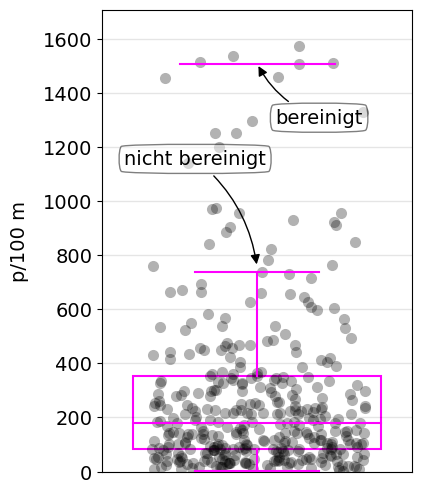

In [18]:
# implementation of medcouple
a_whis = medcouple(dt_all[unit_label].to_numpy())

# get the ecdf 
ecdf = ECDF(dt_all[unit_label].to_numpy())

# quantiles and IQR of the data
q1 = dt_all[unit_label].quantile(0.25)
q3 =dt_all[unit_label].quantile(0.75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

fig, ax = plt.subplots(figsize=(4,6))
box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'magenta'},
    'medianprops':{'color':'magenta'},
    'whiskerprops':{'color':'magenta'},
    'capprops':{'color':'magenta'}
}

sns.stripplot(data=dt_all, y=unit_label, ax=ax, zorder=1, color='black', jitter=.35, alpha=0.3, s=8)
sns.boxplot(data=dt_all, y=unit_label, ax=ax, zorder=3, orient='v', showfliers=False, **box_props)
ax.axhline(y=a_2fence, xmin=.25, xmax=.75, c='magenta', zorder=3,)
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='x', bottom=False)

ax.set_ylim(0, a_2fence+200)

ax.annotate("bereinigt",
                  xy=(0, a_2fence), xycoords='data',
                  xytext=(.2,a_2fence-200), textcoords='data',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w", alpha=0.5),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="black"),)

ax.annotate("nicht bereinigt",
                  xy=(0, limit_upper), xycoords='data',
                  xytext=(-.2,limit_upper+400), textcoords='data',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w",alpha=0.5),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="black"),)
ax.grid(visible=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.1, zorder=0)

figure_name = "tukeys_example"
tukeys_example_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":tukeys_example_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
tukeys_caption = [
    "Die Grenze, ab der eine Datenerhebung als extrem gilt, erstreckt sich auf das 98. ",
    "Perzentil, wenn die Boxplots angepasst werden, im Gegensatz zum 90. Perzentil, ",
    "wenn die Konstante bei 1,5 belassen wird. ",
    "Der Unterschied zwischen bereinigten und normalen Boxplots. Bereinigt = 1’507 p/100, m",
    "nicht bereinigt = 755 p/100 m."
]

tukeys_example_notes = ''.join(tukeys_caption)

glue("tukeys_example_notes", tukeys_example_notes, display=False)


glue("tukeys_example", fig, display=False)
plt.close()

```{glue:figure} tukeys_example
---
name: 'tukeys_example'
---
` `
```
{numref}`Abbildung %s: <tukeys_example>` {glue:text}`tukeys_example_notes`

In [19]:
fig_13_cap = makeAParagraph(f"<b>Rechts:</b> {tukeys_caption}", style=caption_style)

figure_kwargs.update({
    "image_file":tukeys_example_file_name,
    "original_width":10.16,
    "original_height":15.24,
    "desired_width": 7.9,
    "caption":None,
})

figure_13 = figureAndCaptionTable(**figure_kwargs)

p_40 = [
    "Bei Verwendung der bereinigten Boxplots steigt die Extremwertschwelle (EVT) auf ",
    "über 1600 p/100 m. Die unbereinigten Boxplots liegen jedoch innerhalb des KI des ",
    "erwarteten Perzentils der Erhebungsdaten."
]

p_40 = makeAParagraph(p_40)

p_41 = [
    "<b>Unten:</b> Beispiel für bereinigte Extremwerte: St. Gingolph, 12.08.2020. Es ",
    "wurden 514 Objekte (p) über 31 Meter (m) Uferlinie gesammelt. Zuerst wird der Wert ",
    "der Datenerhebungen in Abfallobjekte pro Meter (p/m) umgerechnet und dann mit der ",
    "erforderlichen Anzahl von Metern (100) multipliziert: ",
    "<br/>(p/m)*100 = (514_{p} / 31_m)*100m ≈1652 p/100 m"
]

p_41 = makeAParagraph(p_41, style=caption_style)

table_data = [[[fig_13_cap, small_space, smallest_space, p_40, small_space, small_space, p_41], figure_13]]

tukeys_figure = Table(table_data, style=featuredata.side_by_side_style_figure_right, colWidths=[8.3*cm, 8.3*cm])
    
new_components = [
    small_space,
    extreme_section,
    small_space,
    *p_32_to_33,
    p_34,
    smallest_space,
    extreme_def,
    smallest_space,
    p_35,
    smallest_space,
    boxplots_def,
    smallest_space,
    p_36,
    smallest_space,
    tukeys_normal,
    smallest_space,
    p_37,
    smallest_space,
    medcouple_header,
    smallest_space,
    medcouple_list,
    smallest_space,
    p_38,
    smallest_space,
    tukeys_figure,  
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

Der Unterschied zwischen bereinigten und normalen Boxplots. Bereinigt = 1507 p/100 m, nicht bereinigt = 755 p/100 m.

Bei Verwendung der bereinigten Boxplots steigt die Extremwertschwelle (EVT) auf über 1600 p/100 m. Die unbereinigten Boxplots liegen jedoch innerhalb des KI des erwarteten Perzentils der Erhebungsdaten.

```{figure} resources/images/baselines/onethous60053pcs100m.jpg
:name: onethous60053pcs100m


` `

```

{numref}`Abbildung {number}: <onethous60053pcs100m>` Beispiel für bereinigte Extremwerte: St. Gingolph, 12.08.2020. Es wurden 514 Objekte (p) über 31 Meter (m) Uferlinie gesammelt. Zuerst wird der Wert der Datenerhebungen in Abfallobjekte pro Meter (p/m) umgerechnet und dann mit der erforderlichen Anzahl von Metern (100) multipliziert: $(pcs/m)*100 = (514_{pcs} / 31_m)*100m \approxeq  \text{1'652 p/100 m}$

In [20]:
figure_kwargs.update({
    "image_file":"resources/images/baselines/onethous60053pcs100m.jpg",
    "original_width":14.9,
    "original_height":6.7,
    "desired_width": 15,
    "caption":None,
})

figure_13 = figureAndCaptionTable(**figure_kwargs)

#### Modellierung 

Extremwerte können identifiziert werden, indem man davon ausgeht, dass die Daten zu einer zugrundeliegenden bekannten statistischen Verteilung gehören. Im Allgemeinen wird davon ausgegangen, dass Zähldaten eine Poisson-Verteilung oder eine sehr ähnliche Form aufweisen. Bei der Poisson-Verteilung wird angenommen, dass der Mittelwert gleich der Varianz ist. Die vorliegenden Daten und Strandabfalldaten im Allgemeinen weisen eine hohe Varianz auf, die in der Regel grösser als der Mittelwert ist. 

Für die negative Binomialverteilung (NB) gilt diese Anforderung nicht. Die NB ist eine Poisson-Verteilung mit dem Parameter λ, wobei λ selbst nicht fest ist, sondern eine Zufallsvariable, die einer Gamma-Verteilung folgt. {cite}`cameron` {cite}`wolfram` {cite}`nbinom` 

> Der Modellierungsansatz zur Identifizierung von Extremwerten erfolgt dann durch Anpassung der NB-Verteilung an die Daten mittels maximaler Wahrscheinlichkeit (MLE) und Kennzeichnung aller Werte im rechten Schwanz als potenziell extreme Werte, wenn die Wahrscheinlichkeit, dass sie zur angepassten NB-Verteilung gehören, kleiner als z.B. 0,001 ist.  {cite}`threshholdeu`

Der MLE ist eine der beiden empfohlenen Methoden zur Modellierung oder Anpassung von Datenwerten an eine angenommene Verteilung:

* Methode der Momente (MOM) 
* MLE: Maximum-Likelihood-Schätzung 

##### Methode der Momente (MOM)

Die Methode der Momente geht davon aus, dass die aus der Stichprobe abgeleiteten Parameter den Populationsparametern nahekommen oder gleich sind. Im Falle von Strand-Abfallerhebungen bedeutet dies, dass der Median, der Mittelwert und die Varianz der Stichprobe als gute Annäherung an die tatsächlichen Werte angesehen werden können, wenn alle Strände an allen Seen und Fliessgewässern untersucht werden. 

Konkret werden die Parameter eines wahrscheinlichen Verteilungsmodells geschätzt, indem sie aus den Beispieldaten berechnet werden. Diese Methode ist einfach anzuwenden, da die meisten Parameterberechnungen für die gängigsten Verteilungen gut bekannt sind. {cite}`srikanta` {cite}`2020SciPy` {cite}`examplemmoments`

##### Maximum-Likelihood-Schätzung (MLE)

MLE ist eine Methode zur Schätzung der Parameter eines statistischen Modells bei gegebenen Daten. In dieser Hinsicht unterscheidet sie sich nicht von der MOM. Der Unterschied besteht darin, dass bei der MOM die Modellparameter aus den Daten berechnet werden, während bei der MLE die Parameter so gewählt werden, dass die Daten angesichts des statistischen Modells am wahrscheinlichsten sind. 

Diese Methode ist rechenintensiver als die MOM, hat aber einige Vorteile:

* Wenn das Modell korrekt angenommen wird, ist MLE die effizienteste Schätzung.
* MLE führt zu unverzerrten Schätzungen in grösseren Stichproben. 

In [21]:
model_section_title = Paragraph("Modellierung", section_title)

p_42 = [
    "Extremwerte können identifiziert werden, indem man davon ausgeht, dass die Daten zu einer ",
    "zugrundeliegenden bekannten statistischen Verteilung gehören. Im Allgemeinen wird davon ausgegangen, ",
    "dass Zähldaten eine Poisson-Verteilung oder eine sehr ähnliche Form aufweisen. Bei der ",
    "Poisson-Verteilung wird angenommen, dass der Mittelwert gleich der Varianz ist. Die vorliegenden ",
    "Daten und Strandabfalldaten im Allgemeinen weisen eine hohe Varianz auf, die in der Regel grösser ",
    "als der Mittelwert ist."
]

p_43 = [
    "Für die negative Binomialverteilung (NB) gilt diese Anforderung nicht. Die NB ist eine ",
    "Poisson-Verteilung mit dem Parameter λ, wobei λ selbst nicht fest ist, sondern eine ",
    "Zufallsvariable, die einer Gamma-Verteilung folgt.",
    '<a href="#CT99" color="blue">(CT99)</a><a href="#Wei20" color="blue">(Wei20)</a><a href="#nbi" color="blue">(nbi)</a>'
]

p42_43 = sectionParagraphs([p_42, p_43], smallspace=smallest_space)

p_44 = [
    '"Der Modellierungsansatz zur Identifizierung von Extremwerten erfolgt dann durch Anpassung der ',
    "NB-Verteilung an die Daten mittels maximaler Wahrscheinlichkeit (MLE) und Kennzeichnung aller ",
    "Werte im rechten Schwanz als potenziell extreme Werte, wenn die Wahrscheinlichkeit, dass sie ",
    'zur angepassten NB-Verteilung gehören, kleiner als z.B. 0,001 ist."',
    '<a href="#VLW20" color="blue">(VLW20)</a>'
]

p_44 = makeAParagraph(p_44, style=block_quote_style)

p_45 = [
    "Der MLE ist eine der beiden empfohlenen Methoden zur ",
    "Modellierung oder Anpassung von Datenwerten an eine angenommene Verteilung:"
]

p_45 = makeAParagraph(p_45)

t_models_list =[
    "Methode der Momente (MOM)",
    "MLE: Maximum-Likelihood-Schätzung",
]

t_models_list = makeAList(t_models_list)

mom_title = Paragraph("Methode der Momente (MOM)", style=bold_block)

p_46 = [
    "Die Methode der Momente geht davon aus, dass die aus der Stichprobe abgeleiteten Parameter ",
    "den Populationsparametern nahekommen oder gleich sind. Im Falle von Strand-Abfallerhebungen ",
    "bedeutet dies, dass der Median, der Mittelwert und die Varianz der Stichprobe als gute Annäherung ",
    "an die tatsächlichen Werte angesehen werden können, wenn alle Strände an allen Seen und Fliessgewässern ",
    "untersucht werden."
]

p_47 = [
    "Konkret werden die Parameter eines wahrscheinlichen Verteilungsmodells geschätzt, ",
    "indem sie aus den Beispieldaten berechnet werden. Diese Methode ist einfach anzuwenden, ",
    "da die meisten Parameterberechnungen für die gängigsten Verteilungen gut bekannt sind.",
    '<a href="#MDG18" color="blue">(MDG18)</a><a href="#VGO+20" color="blue">(VGO+20)</a>'
]

p_46_47 = sectionParagraphs([p_46, p_47], smallspace=smallest_space)

mle_title = Paragraph("Maximum-Likelihood-Schätzung (MLE)", style=bold_block)

p_48 = [
    "MLE ist eine Methode zur Schätzung der Parameter eines statistischen Modells bei gegebenen Daten. ",
    "In dieser Hinsicht unterscheidet sie sich nicht von der MOM. Der Unterschied besteht darin, dass ",
    "bei der MOM die Modellparameter aus den Daten berechnet werden, während bei der MLE die Parameter ",
    "so gewählt werden, dass die Daten angesichts des statistischen Modells am wahrscheinlichsten sind."
]

p_49 = [
    "Diese Methode ist rechenintensiver als die MOM, hat aber einige Vorteile:"
]

p_48_49 = sectionParagraphs([p_48, p_49], smallspace=smallest_space)

mle_list = [
    "Wenn das Modell korrekt angenommen wird, ist MLE die effizienteste Schätzung.",
    "MLE führt zu unverzerrten Schätzungen in grösseren Stichproben."
]

mle_list = makeAList(mle_list)

nbipub = [
    "Scipy stats nbinom. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html"
]

nbi = makeAParagraph(featuredata.makeBibEntry(name="nbi", team="SciPy, NumFocus", pub=nbipub[0]))

weipub = [
    "negative binomial distribution. from mathworld–a wolfram web resource. 2020. URL: https://mathworld.wolfram.com/NegativeBinomialDistribution.html."
]

wei20 = makeAParagraph(featuredata.makeBibEntry(name="Wei20", team="Wolfram-mathworld", pub=weipub[0]))

ct99pub = [
    "Regression analysis of count data. 2nd ed, pages 200. Volume 41. cambridge, 09 1999. doi:10.1017/CBO9780511814365."
]

ct99 = makeAParagraph(featuredata.makeBibEntry(name="CT99", team="A. Cameron and Pravin Trivedi", pub=ct99pub[0]))

mdg18pub = [
    "Chapter 3 - distributions and models thereof. In Srikanta Mishra ",
    "and Akhil Datta-Gupta, editors, Applied Statistical Modeling and Data Analytics, pages 31–67. Elsevier, 2018. ",
    "URL: https://www.sciencedirect.com/science/article/pii/B9780128032794000031, doi:https://doi.org/10.1016/B978-0-12-803279-4.00003-1."
]
mdg18pub = ''.join(mdg18pub)

mdg18 = makeAParagraph(featuredata.makeBibEntry(name="MDG18", team="Srikanta Mishra and Akhil Datta-Gupta.", pub=mdg18pub))

vgo20pub = [
    "SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17:261–272, 2020. doi:10.1038/s41592-019-0686-2."
]

vgo20team = [
    "Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, ",
    "Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, C J Carey, İlhan Polat, Yu Feng, ",
    "Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E. A. Quintero, Charles R. Harris, Anne M. Archibald, Antônio H. Ribeiro, ",
    "Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors."
]

vgo20 = makeAParagraph(featuredata.makeBibEntry(name="VGO+20", team=''.join(vgo20team), pub=vgo20pub[0]))

sopub = [
    "Fitting for discrete data: negative binomial, poisson, geometric distribution. ",
    
]

somle = makeAParagraph(featuredata.makeBibEntry(name="SO", team="Stack-Overflow", pub=sopub[0]))

references = [*references, smallest_space, ct99, smallest_space, wei20, smallest_space, nbi, smallest_space, mdg18, smallest_space, vgo20, smallest_space, somle]

new_components = [
    small_space,
    figure_13,
    small_space,
    model_section_title,
    small_space,
    *p42_43,
    p_44,
    smallest_space,
    p_45,
    smallest_space,
    t_models_list,
    smallest_space,
    mom_title,
    smallest_space,
    *p_46_47,
    mle_title,
    smallest_space,
    *p_48_49,
    mle_list,
    smallest_space,   
]
pdfcomponents = addToDoc(new_components, pdfcomponents)

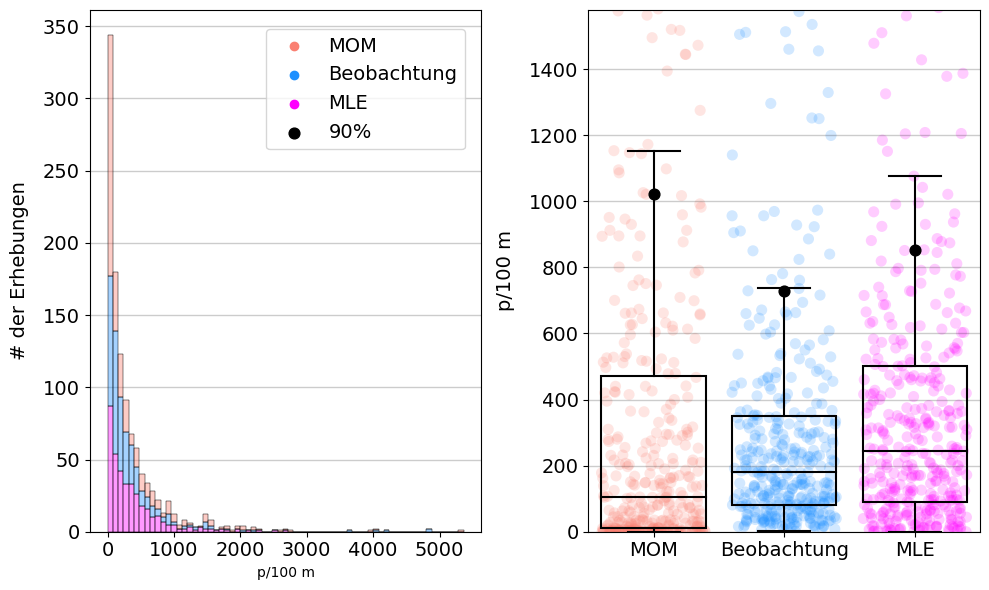

In [22]:
# implementaion of MLE
# https://github.com/pnxenopoulos/negative_binomial/blob/master/negative_binomial/core.py

def r_derv(r_var, vec):
    ''' Function that represents the derivative of the negbinomial likelihood
    '''

    total_sum = 0
    obs_mean = np.mean(vec)  # Save the mean of the data
    n_pop = float(len(vec))  # Save the length of the vector, n_pop

    for obs in vec:
        total_sum += digamma(obs + r_var)

    total_sum -= n_pop*digamma(r_var)
    total_sum += n_pop*math.log(r_var / (r_var + obs_mean))

    return total_sum

def p_equa(r_var, vec):
    ''' Function that represents the equation for p in the negbin likelihood
     '''
    data_sum = sum(vec)
    n_pop = float(len(vec))
    p_var = 1 - (data_sum / (n_pop * r_var + data_sum))
    return p_var

def neg_bin_fit(vec, init=0.0001):
    ''' Function to fit negative binomial to data
    vec: the data vector used to fit the negative binomial distribution
   
    '''
    est_r = newton(r_derv, init, args=(vec,))
    est_p = p_equa(est_r, vec)
    return est_r, est_p

# the data to model
vals = dt_all[unit_label].to_numpy()

# the variance
var = np.var(vals)

# the average
mean = np.mean(vals)

# dispersion
p = (mean/var)
n = (mean**2/(var-mean))

# implementation of method of moments
r = stats.nbinom.rvs(n,p, size=len(vals))

# format data for charting
df = pd.DataFrame({unit_label:vals, 'group':"Beobachtung"})
df = pd.concat([df, pd.DataFrame({unit_label:r, 'group':'MOM'})])

scp = df[df.group == 'MOM'][unit_label].to_numpy()
obs = df[df.group == "Beobachtung"][unit_label].to_numpy()

scpsx = [{unit_label:x, 'model':'MOM'} for x in scp]
obsx = [{unit_label:x, 'model':"Beobachtung"} for x in obs]

# ! implementation of MLE
estimated_r, estimated_p = neg_bin_fit(obs, init = 0.0001)

# ! use the MLE estimators to generate data
som_data = stats.nbinom.rvs(estimated_r, estimated_p, size=len(dt_all))
som_datax = pd.DataFrame([{unit_label:x, 'model':'MLE'}  for x in som_data])

# combined the different results in to one df
data = pd.concat([pd.DataFrame(scpsx), pd.DataFrame(obsx), pd.DataFrame(som_datax)])
data.reset_index(inplace=True)

# the 90th
ev = data.groupby('model', as_index=False)[unit_label].quantile(.9)
xval={'MOM':0, 'Beobachtung':1, 'MLE':2}
ev['x'] = ev.model.map(lambda x: xval[x])
box_palette = {'MOM':'salmon', 'MLE':'magenta', 'Beobachtung':'dodgerblue'}

fig, axs = plt.subplots(1,2, figsize=(10,6))

ax=axs[0]
axone=axs[1]

bw=80

sns.histplot(data=data, x=unit_label, ax=ax, hue='model', zorder=2, palette=box_palette, binwidth=bw, element='bars', multiple='stack', alpha=0.4)
# sns.histplot(data=data, x=unit_label, ax=ax, hue='model')
box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(data=data, x='model', y=unit_label, ax=axone, zorder=5, palette=box_palette, showfliers=False, dodge=False, **box_props)
sns.stripplot(data=data, x='model', y=unit_label, hue='model', zorder=0,palette=box_palette, ax=axone, s=8, alpha=0.2, dodge=False, jitter=0.4)
axone.scatter(x=ev.x.values, y=ev[unit_label].values, label="90%", color='black', s=60)
axone.set_ylim(0,np.percentile(r, 95))
ax.get_legend().remove()
ax.set_ylabel("# der Erhebungen", **ck.xlab_k14)
axone.set_ylabel(unit_label, **ck.xlab_k14)

handles, labels = axone.get_legend_handles_labels()
axone.get_legend().remove()
h3=handles[:3]
hlast= handles[-1:]
axone.set_xlabel("")
axone.tick_params(which='both', axis='both', labelsize=14)
ax.tick_params(which='both', axis='both', labelsize=14)
l3 = labels[:3]
llast = labels[-1:]

ax.grid(visible=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.2, zorder=0)
axone.grid(visible=True, which='major', axis='y', linestyle='-', linewidth=1, c='black', alpha=.2, zorder=0)

fig.legend([*h3, *hlast], [*l3, *llast], bbox_to_anchor=(.48, .96), loc='upper right', fontsize=14)
plt.tight_layout()

figure_name = "models_compare"
models_compare_file_name = f'{save_fig_prefix}{figure_name}.jpeg'
save_figure_kwargs.update({"fname":models_compare_file_name})
plt.savefig(**save_figure_kwargs)

# figure caption
models_compare_caption = [
    "<b>Anpassen der Daten an die zugrundeliegende NB-Verteilung.</b> Die beobachteten Erhebungsergebnisse werden ",
    "mit den geschätzten Datenerhebungen unter Verwendung der Methode der Momente und der Maximum-Likelihood-Schätzung ",
    "verglichen. <b>Links:</b> Histogramm der Ergebnisse im Vergleich zu den beobachteten Daten. <b>Rechts:</b> Verteilung ",
    "der Ergebnisse im Vergleich zu den beobachteten Daten mit 90. Perzentil. 90% p/100m:  MLE=825,  Observed=727,  MOM=888"
]

models_compare_notes = ''.join(models_compare_caption)

glue("models_compare", fig, display=False)

plt.close()

```{glue:figure} models_compare
---
name: 'models_compare'
---
` `
```
{numref}`Abbildung %s: <models_compare>` __Anpassen der Daten an die zugrundeliegende NB-Verteilung.__ Die beobachteten Erhebungsergebnisse werden mit den geschätzten Datenerhebungen unter Verwendung der Methode der Momente und der Maximum-Likelihood-Schätzung verglichen. __Links:__ Histogramm der Ergebnisse im Vergleich zu den beobachteten Daten. __Rechts:__ Verteilung der Ergebnisse im Vergleich zu den beobachteten Daten mit 90. Perzentil.

In [23]:
fig_15_cap = makeAParagraph(models_compare_notes, caption_style)

figure_kwargs.update({
    "image_file":models_compare_file_name,
    "original_width":25.4,
    "original_height":15.24,
    "desired_width": 16,
    "caption":fig_15_cap,
    "caption_height":2,
})

figure_15 = figureAndCaptionTable(**figure_kwargs)

new_components = [
    smallest_space,
    figure_15,
    PageBreak()
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

## Umsetzung

Die vorgeschlagenen Bewertungsmassstäbe und -methoden für die Ergebnisse der Untersuchungen der Strand-Abfallaufkommen sind ähnlich und kompatibel mit den zuvor in der Schweiz angewandten Methoden. Diese erste Analyse hat gezeigt:

* dass die von der EU vorgeschlagenen Methoden zur Überwachung von Abfallobjekten in der Schweiz anwendbar sind,
* dass Konfidenzintervalle und Basislinien für verschiedene Erhebungsgebiete berechnet werden können und
* dass aggregierte Ergebnisse zwischen Regionen verglichen werden können.

Sobald der BV für ein Erhebungsgebiet berechnet ist, können alle Proben, die innerhalb dieses Erhebungsgebiets durchgeführt werden, direkt mit diesem verglichen werden. Es zeigt sich, dass die Erhebungsgebiete in der Schweiz unterschiedliche Median-Basislinien haben. Diese Situation ist mit der EU vergleichbar, was die Unterschiede zwischen den verschiedenen Regionen und Verwaltungsgebieten betrifft.

Durch die Anwendung der vorgeschlagenen Methoden auf die aktuellen Ergebnisse von IQAASL können die zu untersuchenden Objekte für jedes Untersuchungsgebiet identifiziert werden.

```{figure} resources/images/baselines/lakes_rivers_de_22_0.png
:name: lakes_rivers_de_22_0


` `

```
{numref}`Abbildung {number}: <lakes_rivers_de_22_0>` ergleich der BVs der häufigsten Objekte. Alle Datenerhebungen 2020–2021. Das Erhebungsgebiet Ticino/Ceresio hat weniger als 100 Datenerhebungen.

Der erwartete Medianwert pro Datenerhebung und der Medianwert der häufigsten Objekte pro Erhebung ist im Erhebungsgebiet Rhône höher. Wenn der Medianwert verwendet wird, zeigt der BV auch, dass 2/12 der häufigsten Objekte in weniger als 50 % der Datenerhebungen landesweit gefunden wurden, nämlich diejenigen mit einem Medianwert von Null.

Die Methode kann vertikal skaliert werden, um eine detailliertere Ansicht eines Erhebungsgebiets zu erhalten. Die Berechnungsmethode bleibt dieselbe, daher sind Vergleiche vom See bis zur nationalen Ebene möglich. 

```{figure} resources/images/baselines/aare_sa_de_23_0.png
:name: aare_sa_de_23_0


` `

```
{numref}`Abbildung {number}: <aare_sa_de_23_0>` Vergleich der Basiswerte der häufigsten Objekte. Erhebungsgebiet Aare, Seen und Fliessgewässer 2020–2021. Orte mit mehr als 30 Datenerhebungen: Bielersee, Neuenburgersee und Thunersee.

In [24]:
implement_title = Paragraph("Umsetzung", section_title)

p_50 = [
    "Die vorgeschlagenen Bewertungsmassstäbe und -methoden für die Ergebnisse der ",
    "Untersuchungen der Strand-Abfallaufkommen sind ähnlich und kompatibel mit ",
    "den zuvor in der Schweiz angewandten Methoden. Diese erste Analyse hat gezeigt:"
]
p_50 =makeAParagraph(p_50)

implement_list = [
    "dass die von der EU vorgeschlagenen Methoden zur Überwachung von Abfallobjekten in der Schweiz anwendbar sind",
    "dass Konfidenzintervalle und Basislinien für verschiedene Erhebungsgebiete berechnet werden können und",
    "dass aggregierte Ergebnisse zwischen Regionen verglichen werden können."
]
implement_list = makeAList(implement_list)

p_51 =[
    "Sobald der BV für ein Erhebungsgebiet berechnet ist, können alle Proben, die innerhalb dieses Erhebungsgebiets ",
    "durchgeführt werden, direkt mit diesem verglichen werden. Es zeigt sich, dass die Erhebungsgebiete in der Schweiz ",
    "unterschiedliche Median-Basislinien haben. Diese Situation ist mit der EU vergleichbar, ",
    "was die Unterschiede zwischen den verschiedenen Regionen und Verwaltungsgebieten betrifft."
]

p_52 = [
    "Durch die Anwendung der vorgeschlagenen Methoden auf die aktuellen Ergebnisse von IQAASL ",
    "können die zu untersuchenden Objekte für jedes Untersuchungsgebiet identifiziert werden."
]

p_51_52 = sectionParagraphs([p_51, p_52], smallspace=smallest_space)

fig_16_cap = [
    "Vergleich der BVs der häufigsten Objekte. Alle Datenerhebungen 2020–2021. ",
    "Das Erhebungsgebiet Ticino/Ceresio hat weniger als 100 Datenerhebungen."
]

fig_16_cap = makeAParagraph(fig_16_cap, caption_style)

figure_kwargs.update({
    "image_file":"resources/images/baselines/lakes_rivers_de_22_0.png",
    "original_width":20.1,
    "original_height":27.055,
    "desired_width": 10,
    "caption":fig_16_cap,
    "caption_height":1.5,
})

figure_16 = figureAndCaptionTable(**figure_kwargs)

p_53 = [
    "Der erwartete Medianwert pro Datenerhebung und der Medianwert der häufigsten Objekte pro Erhebung ist im Erhebungsgebiet Rhône höher. ",
    "Wenn der Medianwert verwendet wird, zeigt der BV auch, dass 2/12 der häufigsten Objekte in weniger als 50 % der Datenerhebungen landesweit ",
    "gefunden wurden, nämlich diejenigen mit einem Medianwert von Null."
]

p_54 = [
    "Die Methode kann vertikal skaliert werden, um eine detailliertere Ansicht eines Erhebungsgebiets zu erhalten. ",
    "Die Berechnungsmethode bleibt dieselbe, daher sind Vergleiche vom See bis zur nationalen Ebene möglich."
]

p_53_54 = sectionParagraphs([p_53, p_54], smallspace=smallest_space)

fig_17_cap = [
    "Vergleich der Basiswerte der häufigsten Objekte. Erhebungsgebiet Aare, Seen und Fliessgewässer 2020–2021. ",
    "Orte mit mehr als 30 Datenerhebungen: Bielersee, Neuenburgersee und Thunersee."
]

fig_17_cap = makeAParagraph(fig_17_cap, caption_style)

figure_kwargs.update({
    "image_file":"resources/images/baselines/aare_sa_de_23_0.png",
    "original_width":30.1,
    "original_height":25.6,
    "desired_width": 16,
    "caption":fig_17_cap,
    "caption_height":1.5,
})

figure_17 = figureAndCaptionTable(**figure_kwargs)

new_components = [
    implement_title,
    small_space,
    p_50,
    KeepTogether(smallest_space),
    implement_list,
    KeepTogether(smallest_space),
    *p_51_52,
    figure_16,
    KeepTogether(smallest_space),
    *p_53_54,
    figure_17,    
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

Die empfohlene Mindestanzahl von Datenerhebungen (40) pro Probenahmezeitraum soll sicherstellen, dass die BV-Berechnungen auf einer ausreichenden Anzahl von Stichproben basieren. Dies ist wegen der hohen Variabilität der Untersuchungen der Strand-Abfallobjekte wichtig.

Die Probenahmen für IQAASL haben im Zeitraum von April 2020 bis Mai 2021 stattgefunden. Unter Berücksichtigung der Mindestanzahl der Proben gibt es drei Basiswerte für das Erhebungsgebiet Aare: 

* Bielersee
* Neuenburgersee
* Erhebungsgebiet Aare  

Für Bewertungszwecke bedeutet dies, dass eine Stichprobe als Stichprobenbewertung dienen kann und die Ergebnisse direkt mit einer der regionalen Basislinien verglichen werden können, was ein sofortiges Feedback ermöglicht. Diese Art der Bewertung vereinfacht den Prozess und versetzt die lokalen Akteure in die Lage, unabhängige Bewertungen vorzunehmen, Schlussfolgerungen zu ziehen und auf der Grundlage der Ergebnisse der festgelegten BVs für das Erhebungsgebiet Minderungsstrategien festzulegen.

In den vorherigen Beispielen sind keine Schwellenwerte oder Extremwerte angegeben. Werte, die grösser als Null sind, entsprechen dem erwarteten Medianwert des Objekts für jede gemessene Einheit. Ein Nullwert bedeutet, dass das Objekt in weniger als 50 % der Datenerhebungen gefunden wurde. Der Perzentil-Rang für ein bestimmtes Objekt lässt sich ableiten, indem die Wertetabelle in horizontaler Richtung gelesen wird. 

Wie aussagekräftig diese Ergebnisse für die Bewertung von Minderungsstrategien sind, hängt von der Anzahl und Qualität der Proben ab. Interessengruppen auf kommunaler oder lokaler Ebene benötigen detaillierte Daten über bestimmte Objekte. Nationale und internationale Stakeholder hingegen tendieren dazu, breitere, aggregierte Gruppen zu verwenden. 

Die Qualität der Daten steht in direktem Zusammenhang mit der Ausbildung und Unterstützung der Personen, die die Datenerhebung durchführen. Der Identifizierungsprozess erfordert ein gewisses Mass an Fachwissen, da viele Objekte und Materialien dem Durchschnittsbürger nicht bekannt sind. Ein Kernteam von erfahrenen Personen, die bei der Entwicklung und Schulung helfen, stellt sicher, dass die Datenerhebungen im Laufe der Zeit konsistent durchgeführt werden. 

Das Monitoring-Programm in der Schweiz hat es geschafft, mit den Entwicklungen auf dem Kontinent Schritt zu halten, es gibt jedoch viele Bereiche, die verbessert werden können:

1. Festlegung einer standardisierten Methode zur Berichterstattung für kommunale, kantonale und nationale Akteure
2. Definition von Monitoring- oder Bewertungszielen
3. Formalisierung des Datenspeichers und der Methode zur Implementierung auf verschiedenen Verwaltungsebenen
4. Aufbau eines Netzwerks von Verbänden, die sich die Verantwortung und die Ressourcen für die Vermessung des Gebiets teilen
5. Entwicklung und Implementierung eines formellen Schulungsprogramms für die Personen, welche die Datenerhebung ausführen
6. Ermittlung der idealen Stichproben-Szenarien und des Forschungsbedarfs mit akademischen Partnern
7. Entwicklung einer Finanzierungsmethode zur Durchführung der empfohlenen Mindestanzahl von Erhebungen (40) pro Erhebungszeitraum und Erhebungsgebiet, um sicherzustellen, dass genaue Bewertungen vorgenommen werden können und die Forschungsanforderungen erfüllt werden.

Veränderungen in den Ergebnissen von Strand-Abfalluntersuchungen sind Signale, und die Verwendung von Basiswerten hilft, das Ausmass dieser Signale zu erkennen. Ohne Kontext oder zusätzliche Informationen können diese Signale jedoch zufällig erscheinen. 

Zum Expertenwissen gehört die Fähigkeit, Erhebungsergebnisse in den Kontext lokaler Ereignisse und der Topographie einzuordnen. Dieses Urteilsvermögen in Bezug auf die Daten und die Umgebung ist für die Identifizierung potenzieller Quellen und Prioritäten von wesentlicher Bedeutung. 

In [25]:
p_55 = [
    "Die empfohlene Mindestanzahl von Datenerhebungen (40) pro Probenahmezeitraum soll sicherstellen, dass die BV-Berechnungen auf einer ",
    "ausreichenden Anzahl von Stichproben basieren. Dies ist wegen der hohen Variabilität der Untersuchungen der Strand-Abfallobjekte wichtig."
]

p_56 = [
    "Die Probenahmen für IQAASL haben im Zeitraum von April 2020 bis Mai 2021 stattgefunden. Unter Berücksichtigung der ",
    "Mindestanzahl der Proben gibt es drei Basiswerte für das Erhebungsgebiet Aare: "
]

p_55_56 = sectionParagraphs([p_55, p_56], smallspace=smallest_space)

lake_list = [
    "Bielersee",
    "Neuenburgersee",
    "Erhebungsgebiet Aare"
]

lake_list = makeAList(lake_list)

p_57 = [
    "Für Bewertungszwecke bedeutet dies, dass eine Stichprobe als Stichprobenbewertung dienen kann und ",
    "die Ergebnisse direkt mit einer der regionalen Basislinien verglichen werden können, was ein ",
    "sofortiges Feedback ermöglicht. Diese Art der Bewertung vereinfacht den Prozess und versetzt die ",
    "lokalen Akteure in die Lage, unabhängige Bewertungen vorzunehmen, Schlussfolgerungen zu ziehen und ",
    "auf der Grundlage der Ergebnisse der festgelegten BVs für das Erhebungsgebiet Minderungsstrategien festzulegen."
]
p_57 = ''.join(p_57)

p_57 = Paragraph(p_57, style=featuredata.p_style)

p_58 = [
    "In den vorherigen Beispielen sind keine Schwellenwerte oder Extremwerte angegeben. Werte, die grösser als ",
    "Null sind, entsprechen dem erwarteten Medianwert des Objekts für jede gemessene Einheit. Ein Nullwert bedeutet, ",
    "dass das Objekt in weniger als 50 % der Datenerhebungen gefunden wurde. Der Perzentil-Rang für ein bestimmtes ",
    "Objekt lässt sich ableiten, indem die Wertetabelle in horizontaler Richtung gelesen wird."
]
p_58 = makeAParagraph(p_58)

p_59 = [
    "Wie aussagekräftig diese Ergebnisse für die Bewertung von Minderungsstrategien sind, hängt von der Anzahl und ",
    "Qualität der Proben ab. Interessengruppen auf kommunaler oder lokaler Ebene benötigen detaillierte Daten über ",
    "bestimmte Objekte. Nationale und internationale Stakeholder hingegen tendieren dazu, breitere, ",
    "aggregierte Gruppen zu verwenden."
]

p_59 = makeAParagraph(p_59)

p_60 = [
    "Die Qualität der Daten steht in direktem Zusammenhang mit der Ausbildung und Unterstützung der Personen, die die ",
    "Datenerhebung durchführen. Der Identifizierungsprozess erfordert ein gewisses Mass an Fachwissen, da viele Objekte ",
    "und Materialien dem Durchschnittsbürger nicht bekannt sind. Ein Kernteam von erfahrenen Personen, die bei der ",
    "Entwicklung und Schulung helfen, stellt sicher, dass die Datenerhebungen im Laufe der Zeit konsistent durchgeführt werden."
]

p_61 = [
    "Das Monitoring-Programm in der Schweiz hat es geschafft, mit den Entwicklungen auf dem Kontinent Schritt zu halten, ", 
    "es gibt jedoch viele Bereiche, die verbessert werden können:"
]

# p_57_59 = sectionParagraphs([p_57, p_58, p_59], smallspace=smallest_space)

p_60_61 = sectionParagraphs([p_60, p_61],smallspace=smallest_space)
last_list = [
    "Festlegung einer standardisierten Methode zur Berichterstattung für kommunale, kantonale und nationale Akteure",
    "Definition von Monitoring- oder Bewertungszielen",
    "Formalisierung des Datenspeichers und der Methode zur Implementierung auf verschiedenen Verwaltungsebenen",
    "Aufbau eines Netzwerks von Verbänden, die sich die Verantwortung und die Ressourcen für die Vermessung des Gebiets teilen",
    "Entwicklung und Implementierung eines formellen Schulungsprogramms für die Personen, welche die Datenerhebung ausführen",
    "Ermittlung der idealen Stichproben-Szenarien und des Forschungsbedarfs mit akademischen Partnern",
    "Entwicklung einer Finanzierungsmethode zur Durchführung der empfohlenen Mindestanzahl von Erhebungen (40) pro Erhebungszeitraum und Erhebungsgebiet, ",
    "um sicherzustellen, dass genaue Bewertungen vorgenommen werden können und die Forschungsanforderungen erfüllt werden."
]

last_list = makeAList(last_list)

p_62 = [
    "Veränderungen in den Ergebnissen von Strand-Abfalluntersuchungen sind Signale, und die Verwendung von Basiswerten hilft, ",
    "das Ausmass dieser Signale zu erkennen. Ohne Kontext oder zusätzliche Informationen können diese Signale jedoch zufällig erscheinen."
]

p_63 = [
    "Zum Expertenwissen gehört die Fähigkeit, Erhebungsergebnisse in den Kontext lokaler Ereignisse und der Topographie einzuordnen. ",
    "Dieses Urteilsvermögen in Bezug auf die Daten und die Umgebung ist für die Identifizierung potenzieller Quellen und Prioritäten von wesentlicher Bedeutung."
]

p_62_63 = sectionParagraphs([p_62, p_63], smallspace=smallest_space)

new_components = [
    *p_55_56,
    lake_list,
    KeepTogether(smallest_space),
    p_57,    
    KeepTogether(smallest_space),
    p_58,
    KeepTogether(smallest_space),
    p_59,
    KeepTogether(smallest_space),
    *p_60_61,
    smallest_space,
    last_list,
    smallest_space,
    *p_62_63, 
    *references
]

pdfcomponents = addToDoc(new_components, pdfcomponents)

In [26]:
doc = SimpleDocTemplate("resources/pdfs/baselines.pdf", pagesize=A4, leftMargin=2.5*cm, rightMargin=2.5*cm, topMargin=2.5*cm, bottomMargin=1.5*cm)
pageinfo= f"IQAASL/Anwendungen/Basiswerte für Abfallobjekte an Gewässern"


source_prefix = "https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/"
source = "baselines.html"

link_to_source = f'{source_prefix}{source}'

def myLaterPages(canvas, doc):
    canvas.saveState()
    canvas.setLineWidth(.001*cm)
    canvas.setFillAlpha(.8)
    canvas.line(2.5*cm, 27.6*cm,  18.5*cm, 27.6*cm) 
    canvas.setFont('Times-Roman',9)
    canvas.drawString(2.5*cm, 1*cm, link_to_source)
    canvas.drawString(18.5*cm, 1*cm,  "S.%d " % (doc.page,))
    canvas.drawString(2.5*cm, 27.7*cm, pageinfo)
    canvas.restoreState()
    
doc.build(pdfcomponents,  onFirstPage=myLaterPages, onLaterPages=myLaterPages)